In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载resnet50预训练模型
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []  # 训练集loss
acc_train = []  # 训练集正确率
loss_val = []  # 验证集loss
acc_val = []  # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_resnet50.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3985 Acc: 50.0000%
	train 1-2: Loss: 0.3681 Acc: 25.0000%
	train 1-3: Loss: 0.3415 Acc: 25.0000%
	train 1-4: Loss: 0.3119 Acc: 25.0000%
	train 1-5: Loss: 0.6948 Acc: 0.0000%
	train 1-6: Loss: 0.7431 Acc: 25.0000%
	train 1-7: Loss: 0.3366 Acc: 25.0000%
	train 1-8: Loss: 0.2764 Acc: 25.0000%
	train 1-9: Loss: 0.5398 Acc: 25.0000%
	train 1-10: Loss: 0.3672 Acc: 25.0000%
	train 1-11: Loss: 0.4566 Acc: 25.0000%
	train 1-12: Loss: 0.5587 Acc: 25.0000%
	train 1-13: Loss: 1.0350 Acc: 0.0000%
	train 1-14: Loss: 0.1964 Acc: 75.0000%
	train 1-15: Loss: 0.6508 Acc: 25.0000%
	train 1-16: Loss: 0.5681 Acc: 0.0000%
	train 1-17: Loss: 0.4862 Acc: 25.0000%
	train 1-18: Loss: 0.6147 Acc: 25.0000%
	train 1-19: Loss: 0.2842 Acc: 50.0000%
	train 1-20: Loss: 0.8313 Acc: 25.0000%
	train 1-21: Loss: 0.7242 Acc: 25.0000%
	train 1-22: Loss: 0.2329 Acc: 75.0000%
	train 1-23: Loss: 0.4601 Acc: 50.0000%
	train 1-24: Loss: 1.0274 Acc: 0.0000%
	train 1-25: Loss: 0.8134 Acc: 0.0000%


	train 1-205: Loss: 1.4402 Acc: 25.0000%
	train 1-206: Loss: 0.5844 Acc: 50.0000%
	train 1-207: Loss: 0.9270 Acc: 0.0000%
	train 1-208: Loss: 0.3975 Acc: 25.0000%
	train 1-209: Loss: 1.6915 Acc: 0.0000%
	train 1-210: Loss: 1.7320 Acc: 0.0000%
	train 1-211: Loss: 1.2863 Acc: 0.0000%
	train 1-212: Loss: 0.5276 Acc: 75.0000%
	train 1-213: Loss: 0.4804 Acc: 50.0000%
	train 1-214: Loss: 0.4845 Acc: 25.0000%
	train 1-215: Loss: 0.3570 Acc: 25.0000%
	train 1-216: Loss: 0.0508 Acc: 100.0000%
	train 1-217: Loss: 1.0701 Acc: 50.0000%
	train 1-218: Loss: 0.8449 Acc: 25.0000%
	train 1-219: Loss: 0.3611 Acc: 75.0000%
	train 1-220: Loss: 0.3919 Acc: 50.0000%
	train 1-221: Loss: 1.5537 Acc: 0.0000%
	train 1-222: Loss: 1.2480 Acc: 50.0000%
	train 1-223: Loss: 1.1094 Acc: 25.0000%
	train 1-224: Loss: 0.5961 Acc: 50.0000%
	train 1-225: Loss: 0.2903 Acc: 25.0000%
	train 1-226: Loss: 1.0364 Acc: 25.0000%
	train 1-227: Loss: 0.5888 Acc: 50.0000%
	train 1-228: Loss: 1.1653 Acc: 25.0000%
	train 1-229: Loss: 

	train 2-44: Loss: 0.2388 Acc: 50.0000%
	train 2-45: Loss: 0.2871 Acc: 50.0000%
	train 2-46: Loss: 0.4620 Acc: 0.0000%
	train 2-47: Loss: 0.1744 Acc: 75.0000%
	train 2-48: Loss: 0.3745 Acc: 50.0000%
	train 2-49: Loss: 0.3931 Acc: 25.0000%
	train 2-50: Loss: 0.1056 Acc: 75.0000%
	train 2-51: Loss: 0.2752 Acc: 75.0000%
	train 2-52: Loss: 0.3627 Acc: 50.0000%
	train 2-53: Loss: 0.2466 Acc: 50.0000%
	train 2-54: Loss: 0.9414 Acc: 25.0000%
	train 2-55: Loss: 0.1433 Acc: 75.0000%
	train 2-56: Loss: 1.1586 Acc: 25.0000%
	train 2-57: Loss: 0.3060 Acc: 50.0000%
	train 2-58: Loss: 1.1800 Acc: 0.0000%
	train 2-59: Loss: 0.1852 Acc: 75.0000%
	train 2-60: Loss: 0.7091 Acc: 25.0000%
	train 2-61: Loss: 0.1443 Acc: 75.0000%
	train 2-62: Loss: 0.3694 Acc: 0.0000%
	train 2-63: Loss: 0.1854 Acc: 50.0000%
	train 2-64: Loss: 0.1511 Acc: 75.0000%
	train 2-65: Loss: 0.2372 Acc: 50.0000%
	train 2-66: Loss: 0.1932 Acc: 75.0000%
	train 2-67: Loss: 0.1626 Acc: 75.0000%
	train 2-68: Loss: 0.3385 Acc: 50.0000%
	tr

	validation 2-1: Loss: 0.0595 Acc: 100.0000%
	validation 2-2: Loss: 0.2770 Acc: 50.0000%
	validation 2-3: Loss: 0.3188 Acc: 25.0000%
	validation 2-4: Loss: 0.6193 Acc: 75.0000%
	validation 2-5: Loss: 1.2537 Acc: 50.0000%
	validation 2-6: Loss: 0.1362 Acc: 75.0000%
	validation 2-7: Loss: 0.9163 Acc: 75.0000%
	validation 2-8: Loss: 0.1212 Acc: 50.0000%
	validation 2-9: Loss: 0.3252 Acc: 25.0000%
	validation 2-10: Loss: 0.3290 Acc: 75.0000%
	validation 2-11: Loss: 0.0329 Acc: 100.0000%
	validation 2-12: Loss: 0.0151 Acc: 100.0000%
	validation 2-13: Loss: 0.1989 Acc: 75.0000%
	validation 2-14: Loss: 0.1166 Acc: 75.0000%
	validation 2-15: Loss: 0.0877 Acc: 75.0000%
	validation 2-16: Loss: 0.2424 Acc: 50.0000%
	validation 2-17: Loss: 0.1819 Acc: 50.0000%
	validation 2-18: Loss: 0.2041 Acc: 75.0000%
	validation 2-19: Loss: 0.2093 Acc: 75.0000%
	validation 2-20: Loss: 0.3212 Acc: 50.0000%
	validation 2-21: Loss: 0.0792 Acc: 100.0000%
	validation 2-22: Loss: 0.1898 Acc: 50.0000%
	validation 2-2

	train 3-84: Loss: 0.3447 Acc: 50.0000%
	train 3-85: Loss: 0.5081 Acc: 50.0000%
	train 3-86: Loss: 0.1664 Acc: 50.0000%
	train 3-87: Loss: 0.3298 Acc: 75.0000%
	train 3-88: Loss: 0.0864 Acc: 100.0000%
	train 3-89: Loss: 0.1966 Acc: 75.0000%
	train 3-90: Loss: 0.2688 Acc: 50.0000%
	train 3-91: Loss: 0.3879 Acc: 25.0000%
	train 3-92: Loss: 0.1076 Acc: 75.0000%
	train 3-93: Loss: 0.1041 Acc: 75.0000%
	train 3-94: Loss: 0.1487 Acc: 50.0000%
	train 3-95: Loss: 0.2591 Acc: 75.0000%
	train 3-96: Loss: 0.1720 Acc: 50.0000%
	train 3-97: Loss: 0.2332 Acc: 50.0000%
	train 3-98: Loss: 0.3786 Acc: 50.0000%
	train 3-99: Loss: 0.3828 Acc: 50.0000%
	train 3-100: Loss: 0.2646 Acc: 50.0000%
	train 3-101: Loss: 0.1957 Acc: 50.0000%
	train 3-102: Loss: 0.3813 Acc: 25.0000%
	train 3-103: Loss: 0.3145 Acc: 25.0000%
	train 3-104: Loss: 0.1690 Acc: 50.0000%
	train 3-105: Loss: 0.2406 Acc: 25.0000%
	train 3-106: Loss: 0.3700 Acc: 25.0000%
	train 3-107: Loss: 0.3392 Acc: 50.0000%
	train 3-108: Loss: 0.1916 Acc:

	validation 3-38: Loss: 0.1386 Acc: 75.0000%
	validation 3-39: Loss: 0.1988 Acc: 50.0000%
	validation 3-40: Loss: 0.2076 Acc: 50.0000%
	validation 3-41: Loss: 0.0341 Acc: 100.0000%
	validation 3-42: Loss: 0.5144 Acc: 75.0000%
	validation 3-43: Loss: 0.2296 Acc: 50.0000%
	validation 3-44: Loss: 0.1034 Acc: 75.0000%
	validation 3-45: Loss: 0.0996 Acc: 75.0000%
	validation 3-46: Loss: 0.0002 Acc: 100.0000%
	validation 3-47: Loss: 0.1439 Acc: 75.0000%
	validation 3-48: Loss: 0.0423 Acc: 100.0000%
	validation 3-49: Loss: 0.0164 Acc: 100.0000%
	validation 3-50: Loss: 0.0525 Acc: 100.0000%
	validation 3-51: Loss: 0.0131 Acc: 100.0000%
	validation 3-52: Loss: 0.1399 Acc: 75.0000%
	validation 3-53: Loss: 0.1184 Acc: 75.0000%
	validation 3-54: Loss: 0.1291 Acc: 75.0000%
	validation 3-55: Loss: 0.0100 Acc: 100.0000%
	validation 3-56: Loss: 0.1069 Acc: 75.0000%
	validation 3-57: Loss: 0.0042 Acc: 100.0000%
	validation 3-58: Loss: 0.1254 Acc: 75.0000%
	validation 3-59: Loss: 0.2395 Acc: 50.0000%
	v

	train 4-125: Loss: 0.4255 Acc: 0.0000%
	train 4-126: Loss: 0.2420 Acc: 75.0000%
	train 4-127: Loss: 0.2029 Acc: 50.0000%
	train 4-128: Loss: 0.1088 Acc: 100.0000%
	train 4-129: Loss: 0.1127 Acc: 100.0000%
	train 4-130: Loss: 0.2816 Acc: 25.0000%
	train 4-131: Loss: 0.3445 Acc: 50.0000%
	train 4-132: Loss: 0.0575 Acc: 100.0000%
	train 4-133: Loss: 0.1816 Acc: 75.0000%
	train 4-134: Loss: 0.0995 Acc: 75.0000%
	train 4-135: Loss: 0.3353 Acc: 25.0000%
	train 4-136: Loss: 0.2852 Acc: 25.0000%
	train 4-137: Loss: 0.1027 Acc: 50.0000%
	train 4-138: Loss: 0.1493 Acc: 75.0000%
	train 4-139: Loss: 0.6374 Acc: 25.0000%
	train 4-140: Loss: 0.2289 Acc: 25.0000%
	train 4-141: Loss: 0.1133 Acc: 100.0000%
	train 4-142: Loss: 0.5250 Acc: 25.0000%
	train 4-143: Loss: 0.2376 Acc: 75.0000%
	train 4-144: Loss: 0.1344 Acc: 75.0000%
	train 4-145: Loss: 0.3209 Acc: 50.0000%
	train 4-146: Loss: 0.2617 Acc: 75.0000%
	train 4-147: Loss: 0.3474 Acc: 50.0000%
	train 4-148: Loss: 0.2858 Acc: 25.0000%
	train 4-149:

	validation 4-73: Loss: 0.2756 Acc: 50.0000%
	validation 4-74: Loss: 0.2139 Acc: 50.0000%
	validation 4-75: Loss: 0.0166 Acc: 100.0000%
	validation 4-76: Loss: 0.1643 Acc: 75.0000%
	validation 4-77: Loss: 0.0394 Acc: 100.0000%
	validation 4-78: Loss: 0.2219 Acc: 50.0000%
	validation 4-79: Loss: 0.6182 Acc: 50.0000%
	validation 4-80: Loss: 0.0812 Acc: 75.0000%
	validation 4-81: Loss: 0.6233 Acc: 50.0000%
	validation 4-82: Loss: 0.0058 Acc: 100.0000%
	validation 4-83: Loss: 0.7041 Acc: 50.0000%
	validation 4-84: Loss: 0.0326 Acc: 100.0000%
	validation 4-85: Loss: 0.1104 Acc: 75.0000%
	validation 4-86: Loss: 0.8888 Acc: 50.0000%
	validation 4-87: Loss: 0.0831 Acc: 75.0000%
	validation 4-88: Loss: 0.2272 Acc: 50.0000%
	validation 4-89: Loss: 0.2735 Acc: 75.0000%
	validation 4-90: Loss: 0.0022 Acc: 100.0000%
	validation 4-91: Loss: 0.0049 Acc: 100.0000%
	validation 4-92: Loss: 0.0763 Acc: 75.0000%
	validation 4-93: Loss: 0.0885 Acc: 75.0000%
	validation 4-94: Loss: 0.0322 Acc: 100.0000%
	va

	train 5-165: Loss: 0.2823 Acc: 50.0000%
	train 5-166: Loss: 0.2432 Acc: 75.0000%
	train 5-167: Loss: 0.1465 Acc: 75.0000%
	train 5-168: Loss: 0.1584 Acc: 75.0000%
	train 5-169: Loss: 0.0952 Acc: 75.0000%
	train 5-170: Loss: 0.0411 Acc: 100.0000%
	train 5-171: Loss: 0.2043 Acc: 50.0000%
	train 5-172: Loss: 0.4760 Acc: 0.0000%
	train 5-173: Loss: 0.0896 Acc: 75.0000%
	train 5-174: Loss: 0.2765 Acc: 50.0000%
	train 5-175: Loss: 0.1614 Acc: 75.0000%
	train 5-176: Loss: 0.2319 Acc: 75.0000%
	train 5-177: Loss: 0.2802 Acc: 50.0000%
	train 5-178: Loss: 0.2472 Acc: 50.0000%
	train 5-179: Loss: 0.1802 Acc: 50.0000%
	train 5-180: Loss: 0.1455 Acc: 50.0000%
	train 5-181: Loss: 0.1271 Acc: 75.0000%
	train 5-182: Loss: 0.3879 Acc: 25.0000%
	train 5-183: Loss: 0.2498 Acc: 50.0000%
	train 5-184: Loss: 0.5215 Acc: 25.0000%
	train 5-185: Loss: 0.3136 Acc: 50.0000%
	train 5-186: Loss: 0.2324 Acc: 50.0000%
	train 5-187: Loss: 0.5224 Acc: 25.0000%
	train 5-188: Loss: 0.2330 Acc: 25.0000%
	train 5-189: Lo

	train 6-1: Loss: 0.2106 Acc: 75.0000%
	train 6-2: Loss: 0.2137 Acc: 25.0000%
	train 6-3: Loss: 0.2939 Acc: 50.0000%
	train 6-4: Loss: 0.4173 Acc: 25.0000%
	train 6-5: Loss: 0.1650 Acc: 75.0000%
	train 6-6: Loss: 0.0121 Acc: 100.0000%
	train 6-7: Loss: 0.0421 Acc: 100.0000%
	train 6-8: Loss: 0.3861 Acc: 75.0000%
	train 6-9: Loss: 0.1381 Acc: 75.0000%
	train 6-10: Loss: 0.0693 Acc: 75.0000%
	train 6-11: Loss: 0.5297 Acc: 25.0000%
	train 6-12: Loss: 0.4198 Acc: 50.0000%
	train 6-13: Loss: 0.2261 Acc: 50.0000%
	train 6-14: Loss: 0.0653 Acc: 100.0000%
	train 6-15: Loss: 0.1078 Acc: 75.0000%
	train 6-16: Loss: 0.2144 Acc: 50.0000%
	train 6-17: Loss: 0.0446 Acc: 100.0000%
	train 6-18: Loss: 0.4902 Acc: 25.0000%
	train 6-19: Loss: 0.3361 Acc: 50.0000%
	train 6-20: Loss: 0.1713 Acc: 75.0000%
	train 6-21: Loss: 0.2070 Acc: 75.0000%
	train 6-22: Loss: 0.2568 Acc: 50.0000%
	train 6-23: Loss: 0.0899 Acc: 100.0000%
	train 6-24: Loss: 0.1395 Acc: 50.0000%
	train 6-25: Loss: 0.1074 Acc: 50.0000%
	tra

	train 6-203: Loss: 0.1279 Acc: 75.0000%
	train 6-204: Loss: 0.3306 Acc: 25.0000%
	train 6-205: Loss: 0.2886 Acc: 50.0000%
	train 6-206: Loss: 0.4021 Acc: 25.0000%
	train 6-207: Loss: 0.3134 Acc: 50.0000%
	train 6-208: Loss: 0.1424 Acc: 50.0000%
	train 6-209: Loss: 0.1846 Acc: 50.0000%
	train 6-210: Loss: 0.2935 Acc: 50.0000%
	train 6-211: Loss: 0.2103 Acc: 75.0000%
	train 6-212: Loss: 0.1443 Acc: 75.0000%
	train 6-213: Loss: 0.1773 Acc: 50.0000%
	train 6-214: Loss: 0.0992 Acc: 100.0000%
	train 6-215: Loss: 0.1128 Acc: 75.0000%
	train 6-216: Loss: 0.0952 Acc: 100.0000%
	train 6-217: Loss: 0.4489 Acc: 50.0000%
	train 6-218: Loss: 0.2899 Acc: 50.0000%
	train 6-219: Loss: 0.1052 Acc: 50.0000%
	train 6-220: Loss: 0.2490 Acc: 25.0000%
	train 6-221: Loss: 0.1570 Acc: 50.0000%
	train 6-222: Loss: 0.1740 Acc: 50.0000%
	train 6-223: Loss: 0.3400 Acc: 75.0000%
	train 6-224: Loss: 0.0977 Acc: 75.0000%
	train 6-225: Loss: 0.1436 Acc: 75.0000%
	train 6-226: Loss: 0.2087 Acc: 25.0000%
	train 6-227: 

	train 7-41: Loss: 0.2512 Acc: 75.0000%
	train 7-42: Loss: 0.3888 Acc: 25.0000%
	train 7-43: Loss: 0.2830 Acc: 50.0000%
	train 7-44: Loss: 0.2125 Acc: 50.0000%
	train 7-45: Loss: 0.2055 Acc: 75.0000%
	train 7-46: Loss: 0.0167 Acc: 100.0000%
	train 7-47: Loss: 0.2575 Acc: 50.0000%
	train 7-48: Loss: 0.5610 Acc: 25.0000%
	train 7-49: Loss: 0.2891 Acc: 75.0000%
	train 7-50: Loss: 0.1606 Acc: 50.0000%
	train 7-51: Loss: 0.0965 Acc: 75.0000%
	train 7-52: Loss: 0.3550 Acc: 50.0000%
	train 7-53: Loss: 0.4653 Acc: 75.0000%
	train 7-54: Loss: 0.1116 Acc: 75.0000%
	train 7-55: Loss: 0.1229 Acc: 75.0000%
	train 7-56: Loss: 0.1622 Acc: 75.0000%
	train 7-57: Loss: 0.0220 Acc: 100.0000%
	train 7-58: Loss: 0.1463 Acc: 50.0000%
	train 7-59: Loss: 0.0120 Acc: 100.0000%
	train 7-60: Loss: 0.5192 Acc: 50.0000%
	train 7-61: Loss: 0.3781 Acc: 25.0000%
	train 7-62: Loss: 0.9118 Acc: 50.0000%
	train 7-63: Loss: 0.2668 Acc: 50.0000%
	train 7-64: Loss: 0.1911 Acc: 25.0000%
	train 7-65: Loss: 0.3253 Acc: 25.000

	train 7-243: Loss: 0.6888 Acc: 25.0000%
	train 7-244: Loss: 0.0431 Acc: 100.0000%
	train 7-245: Loss: 0.4343 Acc: 50.0000%
	validation 7-1: Loss: 0.7546 Acc: 25.0000%
	validation 7-2: Loss: 0.0002 Acc: 100.0000%
	validation 7-3: Loss: 0.0682 Acc: 100.0000%
	validation 7-4: Loss: 0.0182 Acc: 100.0000%
	validation 7-5: Loss: 0.1248 Acc: 75.0000%
	validation 7-6: Loss: 0.3544 Acc: 75.0000%
	validation 7-7: Loss: 0.2742 Acc: 75.0000%
	validation 7-8: Loss: 0.3470 Acc: 50.0000%
	validation 7-9: Loss: 0.1920 Acc: 75.0000%
	validation 7-10: Loss: 0.0016 Acc: 100.0000%
	validation 7-11: Loss: 0.0093 Acc: 100.0000%
	validation 7-12: Loss: 0.1509 Acc: 50.0000%
	validation 7-13: Loss: 0.4927 Acc: 50.0000%
	validation 7-14: Loss: 0.2836 Acc: 50.0000%
	validation 7-15: Loss: 0.0383 Acc: 100.0000%
	validation 7-16: Loss: 0.1717 Acc: 50.0000%
	validation 7-17: Loss: 0.1394 Acc: 75.0000%
	validation 7-18: Loss: 0.1570 Acc: 50.0000%
	validation 7-19: Loss: 0.1130 Acc: 75.0000%
	validation 7-20: Loss: 

	train 8-81: Loss: 0.1701 Acc: 75.0000%
	train 8-82: Loss: 0.1957 Acc: 50.0000%
	train 8-83: Loss: 0.2087 Acc: 50.0000%
	train 8-84: Loss: 0.1835 Acc: 25.0000%
	train 8-85: Loss: 0.1277 Acc: 75.0000%
	train 8-86: Loss: 0.1699 Acc: 50.0000%
	train 8-87: Loss: 0.0271 Acc: 100.0000%
	train 8-88: Loss: 0.4279 Acc: 50.0000%
	train 8-89: Loss: 0.3466 Acc: 50.0000%
	train 8-90: Loss: 0.2365 Acc: 75.0000%
	train 8-91: Loss: 0.5194 Acc: 25.0000%
	train 8-92: Loss: 0.2414 Acc: 50.0000%
	train 8-93: Loss: 0.5006 Acc: 25.0000%
	train 8-94: Loss: 0.0198 Acc: 100.0000%
	train 8-95: Loss: 0.3437 Acc: 25.0000%
	train 8-96: Loss: 0.1041 Acc: 100.0000%
	train 8-97: Loss: 0.2159 Acc: 50.0000%
	train 8-98: Loss: 0.1277 Acc: 75.0000%
	train 8-99: Loss: 0.0526 Acc: 100.0000%
	train 8-100: Loss: 0.4254 Acc: 50.0000%
	train 8-101: Loss: 0.5705 Acc: 25.0000%
	train 8-102: Loss: 0.0344 Acc: 100.0000%
	train 8-103: Loss: 0.3233 Acc: 50.0000%
	train 8-104: Loss: 0.1663 Acc: 50.0000%
	train 8-105: Loss: 0.1451 Acc

	validation 8-35: Loss: 0.2752 Acc: 50.0000%
	validation 8-36: Loss: 0.0178 Acc: 100.0000%
	validation 8-37: Loss: 0.2093 Acc: 50.0000%
	validation 8-38: Loss: 0.3980 Acc: 75.0000%
	validation 8-39: Loss: 0.2871 Acc: 50.0000%
	validation 8-40: Loss: 0.2103 Acc: 75.0000%
	validation 8-41: Loss: 0.0258 Acc: 100.0000%
	validation 8-42: Loss: 0.1549 Acc: 50.0000%
	validation 8-43: Loss: 0.0553 Acc: 100.0000%
	validation 8-44: Loss: 0.0001 Acc: 100.0000%
	validation 8-45: Loss: 0.0234 Acc: 100.0000%
	validation 8-46: Loss: 0.0576 Acc: 100.0000%
	validation 8-47: Loss: 1.2700 Acc: 75.0000%
	validation 8-48: Loss: 0.0530 Acc: 75.0000%
	validation 8-49: Loss: 0.0752 Acc: 75.0000%
	validation 8-50: Loss: 0.0196 Acc: 100.0000%
	validation 8-51: Loss: 0.0616 Acc: 100.0000%
	validation 8-52: Loss: 0.1671 Acc: 50.0000%
	validation 8-53: Loss: 0.0096 Acc: 100.0000%
	validation 8-54: Loss: 0.2072 Acc: 50.0000%
	validation 8-55: Loss: 0.2848 Acc: 25.0000%
	validation 8-56: Loss: 0.0038 Acc: 100.0000%


	train 9-123: Loss: 0.1398 Acc: 75.0000%
	train 9-124: Loss: 0.1787 Acc: 75.0000%
	train 9-125: Loss: 0.2034 Acc: 75.0000%
	train 9-126: Loss: 0.2332 Acc: 75.0000%
	train 9-127: Loss: 0.2368 Acc: 75.0000%
	train 9-128: Loss: 0.1403 Acc: 75.0000%
	train 9-129: Loss: 0.0895 Acc: 100.0000%
	train 9-130: Loss: 0.2891 Acc: 75.0000%
	train 9-131: Loss: 0.4669 Acc: 25.0000%
	train 9-132: Loss: 0.0384 Acc: 100.0000%
	train 9-133: Loss: 0.3796 Acc: 50.0000%
	train 9-134: Loss: 0.1912 Acc: 75.0000%
	train 9-135: Loss: 0.3402 Acc: 50.0000%
	train 9-136: Loss: 0.0226 Acc: 100.0000%
	train 9-137: Loss: 0.1113 Acc: 75.0000%
	train 9-138: Loss: 0.1871 Acc: 75.0000%
	train 9-139: Loss: 0.1429 Acc: 50.0000%
	train 9-140: Loss: 0.2555 Acc: 75.0000%
	train 9-141: Loss: 0.6097 Acc: 0.0000%
	train 9-142: Loss: 0.0583 Acc: 75.0000%
	train 9-143: Loss: 0.1589 Acc: 75.0000%
	train 9-144: Loss: 0.3298 Acc: 50.0000%
	train 9-145: Loss: 0.0204 Acc: 100.0000%
	train 9-146: Loss: 0.2472 Acc: 25.0000%
	train 9-147:

	validation 9-71: Loss: 0.0116 Acc: 100.0000%
	validation 9-72: Loss: 0.0969 Acc: 75.0000%
	validation 9-73: Loss: 0.0106 Acc: 100.0000%
	validation 9-74: Loss: 0.1048 Acc: 75.0000%
	validation 9-75: Loss: 0.0778 Acc: 75.0000%
	validation 9-76: Loss: 0.0437 Acc: 100.0000%
	validation 9-77: Loss: 0.0307 Acc: 100.0000%
	validation 9-78: Loss: 0.0029 Acc: 100.0000%
	validation 9-79: Loss: 0.0011 Acc: 100.0000%
	validation 9-80: Loss: 0.0865 Acc: 75.0000%
	validation 9-81: Loss: 0.0841 Acc: 100.0000%
	validation 9-82: Loss: 0.0493 Acc: 100.0000%
	validation 9-83: Loss: 0.0332 Acc: 100.0000%
	validation 9-84: Loss: 0.0149 Acc: 100.0000%
	validation 9-85: Loss: 0.0122 Acc: 100.0000%
	validation 9-86: Loss: 0.0181 Acc: 100.0000%
	validation 9-87: Loss: 0.0346 Acc: 100.0000%
	validation 9-88: Loss: 0.1099 Acc: 75.0000%
	validation 9-89: Loss: 0.1232 Acc: 50.0000%
	validation 9-90: Loss: 0.1615 Acc: 50.0000%
	validation 9-91: Loss: 0.0138 Acc: 100.0000%
	validation 9-92: Loss: 0.0071 Acc: 100.0

	train 10-158: Loss: 0.1686 Acc: 75.0000%
	train 10-159: Loss: 0.1815 Acc: 75.0000%
	train 10-160: Loss: 0.2314 Acc: 75.0000%
	train 10-161: Loss: 0.0407 Acc: 100.0000%
	train 10-162: Loss: 0.1660 Acc: 75.0000%
	train 10-163: Loss: 0.0515 Acc: 100.0000%
	train 10-164: Loss: 0.0252 Acc: 100.0000%
	train 10-165: Loss: 0.0499 Acc: 100.0000%
	train 10-166: Loss: 0.0115 Acc: 100.0000%
	train 10-167: Loss: 0.0423 Acc: 100.0000%
	train 10-168: Loss: 0.1654 Acc: 75.0000%
	train 10-169: Loss: 0.2183 Acc: 50.0000%
	train 10-170: Loss: 0.0085 Acc: 100.0000%
	train 10-171: Loss: 0.1015 Acc: 75.0000%
	train 10-172: Loss: 0.1668 Acc: 50.0000%
	train 10-173: Loss: 0.0505 Acc: 100.0000%
	train 10-174: Loss: 0.0088 Acc: 100.0000%
	train 10-175: Loss: 0.0054 Acc: 100.0000%
	train 10-176: Loss: 0.0302 Acc: 100.0000%
	train 10-177: Loss: 0.0155 Acc: 100.0000%
	train 10-178: Loss: 0.0484 Acc: 75.0000%
	train 10-179: Loss: 0.0617 Acc: 75.0000%
	train 10-180: Loss: 0.1031 Acc: 75.0000%
	train 10-181: Loss: 0

	validation 10-101: Loss: 0.6365 Acc: 75.0000%
	validation 10-102: Loss: 0.0160 Acc: 100.0000%
	validation 10-103: Loss: 0.0184 Acc: 100.0000%
	validation 10-104: Loss: 0.2097 Acc: 75.0000%
	validation 10-105: Loss: 0.0665 Acc: 75.0000%
	train Loss: 0.1558 Acc: 74.8980%
	validation Loss: 0.1920 Acc: 80.0000%
Time passed 0h 10m 17s
--------------------
Epoch [11/40]:
	train 11-1: Loss: 0.7342 Acc: 25.0000%
	train 11-2: Loss: 0.5789 Acc: 25.0000%
	train 11-3: Loss: 0.0956 Acc: 75.0000%
	train 11-4: Loss: 0.0909 Acc: 75.0000%
	train 11-5: Loss: 0.3562 Acc: 50.0000%
	train 11-6: Loss: 0.0064 Acc: 100.0000%
	train 11-7: Loss: 0.0320 Acc: 100.0000%
	train 11-8: Loss: 0.3542 Acc: 50.0000%
	train 11-9: Loss: 0.3788 Acc: 75.0000%
	train 11-10: Loss: 0.5357 Acc: 50.0000%
	train 11-11: Loss: 0.3651 Acc: 50.0000%
	train 11-12: Loss: 0.2400 Acc: 75.0000%
	train 11-13: Loss: 0.1523 Acc: 100.0000%
	train 11-14: Loss: 0.0282 Acc: 100.0000%
	train 11-15: Loss: 0.0536 Acc: 100.0000%
	train 11-16: Loss: 

	train 11-189: Loss: 0.0807 Acc: 75.0000%
	train 11-190: Loss: 0.0152 Acc: 100.0000%
	train 11-191: Loss: 0.0574 Acc: 100.0000%
	train 11-192: Loss: 0.0072 Acc: 100.0000%
	train 11-193: Loss: 0.2116 Acc: 50.0000%
	train 11-194: Loss: 0.1766 Acc: 75.0000%
	train 11-195: Loss: 0.4432 Acc: 75.0000%
	train 11-196: Loss: 0.0012 Acc: 100.0000%
	train 11-197: Loss: 0.0353 Acc: 100.0000%
	train 11-198: Loss: 0.0165 Acc: 100.0000%
	train 11-199: Loss: 0.6425 Acc: 50.0000%
	train 11-200: Loss: 0.0041 Acc: 100.0000%
	train 11-201: Loss: 0.0095 Acc: 100.0000%
	train 11-202: Loss: 0.0367 Acc: 100.0000%
	train 11-203: Loss: 0.0221 Acc: 100.0000%
	train 11-204: Loss: 0.1265 Acc: 75.0000%
	train 11-205: Loss: 0.0462 Acc: 100.0000%
	train 11-206: Loss: 0.5937 Acc: 25.0000%
	train 11-207: Loss: 0.2172 Acc: 75.0000%
	train 11-208: Loss: 0.0405 Acc: 100.0000%
	train 11-209: Loss: 0.0510 Acc: 100.0000%
	train 11-210: Loss: 0.0052 Acc: 100.0000%
	train 11-211: Loss: 0.1791 Acc: 75.0000%
	train 11-212: Loss:

	train 12-19: Loss: 0.1700 Acc: 75.0000%
	train 12-20: Loss: 0.4156 Acc: 75.0000%
	train 12-21: Loss: 0.4694 Acc: 50.0000%
	train 12-22: Loss: 0.0365 Acc: 100.0000%
	train 12-23: Loss: 0.0131 Acc: 100.0000%
	train 12-24: Loss: 0.0157 Acc: 100.0000%
	train 12-25: Loss: 0.2705 Acc: 75.0000%
	train 12-26: Loss: 0.0228 Acc: 100.0000%
	train 12-27: Loss: 0.0383 Acc: 100.0000%
	train 12-28: Loss: 0.2370 Acc: 50.0000%
	train 12-29: Loss: 0.0432 Acc: 100.0000%
	train 12-30: Loss: 0.2295 Acc: 75.0000%
	train 12-31: Loss: 0.0194 Acc: 100.0000%
	train 12-32: Loss: 0.0372 Acc: 100.0000%
	train 12-33: Loss: 0.1249 Acc: 75.0000%
	train 12-34: Loss: 0.0394 Acc: 100.0000%
	train 12-35: Loss: 0.4569 Acc: 50.0000%
	train 12-36: Loss: 0.1489 Acc: 50.0000%
	train 12-37: Loss: 0.1151 Acc: 75.0000%
	train 12-38: Loss: 0.1070 Acc: 75.0000%
	train 12-39: Loss: 0.0276 Acc: 100.0000%
	train 12-40: Loss: 0.0464 Acc: 100.0000%
	train 12-41: Loss: 0.0361 Acc: 100.0000%
	train 12-42: Loss: 0.0050 Acc: 100.0000%
	tr

	train 12-216: Loss: 0.0265 Acc: 100.0000%
	train 12-217: Loss: 0.0268 Acc: 100.0000%
	train 12-218: Loss: 0.0605 Acc: 100.0000%
	train 12-219: Loss: 0.0619 Acc: 100.0000%
	train 12-220: Loss: 0.0595 Acc: 75.0000%
	train 12-221: Loss: 0.0772 Acc: 75.0000%
	train 12-222: Loss: 0.2384 Acc: 75.0000%
	train 12-223: Loss: 0.1238 Acc: 75.0000%
	train 12-224: Loss: 0.0360 Acc: 100.0000%
	train 12-225: Loss: 0.1498 Acc: 75.0000%
	train 12-226: Loss: 0.3627 Acc: 75.0000%
	train 12-227: Loss: 0.0135 Acc: 100.0000%
	train 12-228: Loss: 0.0374 Acc: 100.0000%
	train 12-229: Loss: 0.3662 Acc: 25.0000%
	train 12-230: Loss: 0.0448 Acc: 100.0000%
	train 12-231: Loss: 0.0158 Acc: 100.0000%
	train 12-232: Loss: 0.1581 Acc: 50.0000%
	train 12-233: Loss: 0.1845 Acc: 50.0000%
	train 12-234: Loss: 0.0498 Acc: 100.0000%
	train 12-235: Loss: 0.2532 Acc: 25.0000%
	train 12-236: Loss: 0.0780 Acc: 100.0000%
	train 12-237: Loss: 0.0230 Acc: 100.0000%
	train 12-238: Loss: 0.1886 Acc: 75.0000%
	train 12-239: Loss: 0

	train 13-48: Loss: 0.0213 Acc: 100.0000%
	train 13-49: Loss: 0.2178 Acc: 50.0000%
	train 13-50: Loss: 0.0748 Acc: 75.0000%
	train 13-51: Loss: 0.0213 Acc: 100.0000%
	train 13-52: Loss: 0.2163 Acc: 75.0000%
	train 13-53: Loss: 0.0553 Acc: 100.0000%
	train 13-54: Loss: 0.0391 Acc: 100.0000%
	train 13-55: Loss: 0.0366 Acc: 100.0000%
	train 13-56: Loss: 0.2199 Acc: 50.0000%
	train 13-57: Loss: 0.1403 Acc: 75.0000%
	train 13-58: Loss: 0.0243 Acc: 100.0000%
	train 13-59: Loss: 0.2293 Acc: 50.0000%
	train 13-60: Loss: 0.0125 Acc: 100.0000%
	train 13-61: Loss: 0.0860 Acc: 75.0000%
	train 13-62: Loss: 0.0620 Acc: 100.0000%
	train 13-63: Loss: 0.0376 Acc: 100.0000%
	train 13-64: Loss: 0.0150 Acc: 100.0000%
	train 13-65: Loss: 0.0761 Acc: 75.0000%
	train 13-66: Loss: 0.4185 Acc: 50.0000%
	train 13-67: Loss: 0.2784 Acc: 50.0000%
	train 13-68: Loss: 0.1786 Acc: 75.0000%
	train 13-69: Loss: 0.2860 Acc: 50.0000%
	train 13-70: Loss: 0.2174 Acc: 75.0000%
	train 13-71: Loss: 0.4673 Acc: 25.0000%
	train

	train 13-243: Loss: 0.2851 Acc: 75.0000%
	train 13-244: Loss: 0.2614 Acc: 50.0000%
	train 13-245: Loss: 0.2327 Acc: 75.0000%
	validation 13-1: Loss: 0.0201 Acc: 100.0000%
	validation 13-2: Loss: 0.1454 Acc: 50.0000%
	validation 13-3: Loss: 0.0715 Acc: 75.0000%
	validation 13-4: Loss: 0.0031 Acc: 100.0000%
	validation 13-5: Loss: 0.1752 Acc: 75.0000%
	validation 13-6: Loss: 0.0017 Acc: 100.0000%
	validation 13-7: Loss: 0.0666 Acc: 75.0000%
	validation 13-8: Loss: 0.0963 Acc: 75.0000%
	validation 13-9: Loss: 0.1733 Acc: 75.0000%
	validation 13-10: Loss: 0.1817 Acc: 50.0000%
	validation 13-11: Loss: 0.3722 Acc: 75.0000%
	validation 13-12: Loss: 0.0374 Acc: 100.0000%
	validation 13-13: Loss: 0.1252 Acc: 75.0000%
	validation 13-14: Loss: 0.0408 Acc: 100.0000%
	validation 13-15: Loss: 0.0488 Acc: 100.0000%
	validation 13-16: Loss: 0.0261 Acc: 100.0000%
	validation 13-17: Loss: 0.0092 Acc: 100.0000%
	validation 13-18: Loss: 0.2847 Acc: 50.0000%
	validation 13-19: Loss: 0.0074 Acc: 100.0000%


	train 14-76: Loss: 0.0125 Acc: 100.0000%
	train 14-77: Loss: 0.0547 Acc: 100.0000%
	train 14-78: Loss: 0.1150 Acc: 75.0000%
	train 14-79: Loss: 0.0463 Acc: 100.0000%
	train 14-80: Loss: 0.0300 Acc: 100.0000%
	train 14-81: Loss: 0.0215 Acc: 100.0000%
	train 14-82: Loss: 0.0570 Acc: 75.0000%
	train 14-83: Loss: 0.0142 Acc: 100.0000%
	train 14-84: Loss: 0.1209 Acc: 50.0000%
	train 14-85: Loss: 0.0954 Acc: 75.0000%
	train 14-86: Loss: 0.0715 Acc: 75.0000%
	train 14-87: Loss: 0.1221 Acc: 75.0000%
	train 14-88: Loss: 0.0047 Acc: 100.0000%
	train 14-89: Loss: 0.9947 Acc: 25.0000%
	train 14-90: Loss: 0.0597 Acc: 100.0000%
	train 14-91: Loss: 0.0324 Acc: 100.0000%
	train 14-92: Loss: 0.0515 Acc: 100.0000%
	train 14-93: Loss: 0.1822 Acc: 50.0000%
	train 14-94: Loss: 0.0304 Acc: 100.0000%
	train 14-95: Loss: 0.0999 Acc: 75.0000%
	train 14-96: Loss: 0.0063 Acc: 100.0000%
	train 14-97: Loss: 0.0584 Acc: 75.0000%
	train 14-98: Loss: 0.0042 Acc: 100.0000%
	train 14-99: Loss: 0.0400 Acc: 100.0000%
	t

	validation 14-25: Loss: 0.1662 Acc: 75.0000%
	validation 14-26: Loss: 0.4603 Acc: 50.0000%
	validation 14-27: Loss: 0.1089 Acc: 75.0000%
	validation 14-28: Loss: 0.1697 Acc: 75.0000%
	validation 14-29: Loss: 0.2378 Acc: 75.0000%
	validation 14-30: Loss: 0.0749 Acc: 75.0000%
	validation 14-31: Loss: 0.0061 Acc: 100.0000%
	validation 14-32: Loss: 0.0022 Acc: 100.0000%
	validation 14-33: Loss: 0.0044 Acc: 100.0000%
	validation 14-34: Loss: 0.4526 Acc: 50.0000%
	validation 14-35: Loss: 0.0048 Acc: 100.0000%
	validation 14-36: Loss: 0.0043 Acc: 100.0000%
	validation 14-37: Loss: 0.2459 Acc: 75.0000%
	validation 14-38: Loss: 0.2757 Acc: 50.0000%
	validation 14-39: Loss: 0.1636 Acc: 75.0000%
	validation 14-40: Loss: 0.2256 Acc: 75.0000%
	validation 14-41: Loss: 0.2058 Acc: 75.0000%
	validation 14-42: Loss: 0.0766 Acc: 75.0000%
	validation 14-43: Loss: 0.1056 Acc: 75.0000%
	validation 14-44: Loss: 0.0576 Acc: 75.0000%
	validation 14-45: Loss: 0.1080 Acc: 75.0000%
	validation 14-46: Loss: 0.16

	train 15-107: Loss: 0.0220 Acc: 100.0000%
	train 15-108: Loss: 0.0159 Acc: 100.0000%
	train 15-109: Loss: 0.0067 Acc: 100.0000%
	train 15-110: Loss: 0.0505 Acc: 100.0000%
	train 15-111: Loss: 0.0224 Acc: 100.0000%
	train 15-112: Loss: 0.0150 Acc: 100.0000%
	train 15-113: Loss: 0.4063 Acc: 25.0000%
	train 15-114: Loss: 0.1156 Acc: 75.0000%
	train 15-115: Loss: 0.0021 Acc: 100.0000%
	train 15-116: Loss: 0.0182 Acc: 100.0000%
	train 15-117: Loss: 0.3261 Acc: 75.0000%
	train 15-118: Loss: 0.0242 Acc: 100.0000%
	train 15-119: Loss: 0.0656 Acc: 75.0000%
	train 15-120: Loss: 0.0057 Acc: 100.0000%
	train 15-121: Loss: 0.0047 Acc: 100.0000%
	train 15-122: Loss: 0.0606 Acc: 75.0000%
	train 15-123: Loss: 0.0669 Acc: 100.0000%
	train 15-124: Loss: 0.0525 Acc: 75.0000%
	train 15-125: Loss: 0.0451 Acc: 100.0000%
	train 15-126: Loss: 0.2075 Acc: 50.0000%
	train 15-127: Loss: 0.1281 Acc: 75.0000%
	train 15-128: Loss: 0.0152 Acc: 100.0000%
	train 15-129: Loss: 0.0194 Acc: 100.0000%
	train 15-130: Loss

	validation 15-51: Loss: 0.0019 Acc: 100.0000%
	validation 15-52: Loss: 0.0008 Acc: 100.0000%
	validation 15-53: Loss: 0.0060 Acc: 100.0000%
	validation 15-54: Loss: 0.0298 Acc: 100.0000%
	validation 15-55: Loss: 0.0138 Acc: 100.0000%
	validation 15-56: Loss: 0.0328 Acc: 100.0000%
	validation 15-57: Loss: 0.0107 Acc: 100.0000%
	validation 15-58: Loss: 0.0270 Acc: 100.0000%
	validation 15-59: Loss: 0.0769 Acc: 75.0000%
	validation 15-60: Loss: 0.0015 Acc: 100.0000%
	validation 15-61: Loss: 0.0026 Acc: 100.0000%
	validation 15-62: Loss: 0.0035 Acc: 100.0000%
	validation 15-63: Loss: 0.0181 Acc: 100.0000%
	validation 15-64: Loss: 0.0072 Acc: 100.0000%
	validation 15-65: Loss: 0.0087 Acc: 100.0000%
	validation 15-66: Loss: 0.0018 Acc: 100.0000%
	validation 15-67: Loss: 0.0107 Acc: 100.0000%
	validation 15-68: Loss: 0.0011 Acc: 100.0000%
	validation 15-69: Loss: 0.0141 Acc: 100.0000%
	validation 15-70: Loss: 0.0027 Acc: 100.0000%
	validation 15-71: Loss: 0.0048 Acc: 100.0000%
	validation 15

	train 16-132: Loss: 0.0071 Acc: 100.0000%
	train 16-133: Loss: 0.3072 Acc: 50.0000%
	train 16-134: Loss: 0.0149 Acc: 100.0000%
	train 16-135: Loss: 0.0249 Acc: 100.0000%
	train 16-136: Loss: 0.0092 Acc: 100.0000%
	train 16-137: Loss: 0.8588 Acc: 25.0000%
	train 16-138: Loss: 0.1649 Acc: 75.0000%
	train 16-139: Loss: 0.0255 Acc: 100.0000%
	train 16-140: Loss: 0.0281 Acc: 100.0000%
	train 16-141: Loss: 0.0131 Acc: 100.0000%
	train 16-142: Loss: 0.2506 Acc: 50.0000%
	train 16-143: Loss: 0.0093 Acc: 100.0000%
	train 16-144: Loss: 0.0087 Acc: 100.0000%
	train 16-145: Loss: 0.1624 Acc: 75.0000%
	train 16-146: Loss: 0.0548 Acc: 75.0000%
	train 16-147: Loss: 0.0355 Acc: 100.0000%
	train 16-148: Loss: 0.0056 Acc: 100.0000%
	train 16-149: Loss: 0.2796 Acc: 50.0000%
	train 16-150: Loss: 0.1094 Acc: 100.0000%
	train 16-151: Loss: 0.0201 Acc: 100.0000%
	train 16-152: Loss: 0.0023 Acc: 100.0000%
	train 16-153: Loss: 0.3223 Acc: 75.0000%
	train 16-154: Loss: 0.0687 Acc: 75.0000%
	train 16-155: Loss:

	validation 16-74: Loss: 0.0000 Acc: 100.0000%
	validation 16-75: Loss: 0.1834 Acc: 75.0000%
	validation 16-76: Loss: 0.0003 Acc: 100.0000%
	validation 16-77: Loss: 0.0122 Acc: 100.0000%
	validation 16-78: Loss: 0.1451 Acc: 75.0000%
	validation 16-79: Loss: 0.0635 Acc: 75.0000%
	validation 16-80: Loss: 0.0029 Acc: 100.0000%
	validation 16-81: Loss: 0.0113 Acc: 100.0000%
	validation 16-82: Loss: 0.0015 Acc: 100.0000%
	validation 16-83: Loss: 0.0123 Acc: 100.0000%
	validation 16-84: Loss: 0.1311 Acc: 75.0000%
	validation 16-85: Loss: 0.0058 Acc: 100.0000%
	validation 16-86: Loss: 0.1018 Acc: 75.0000%
	validation 16-87: Loss: 0.0011 Acc: 100.0000%
	validation 16-88: Loss: 0.0003 Acc: 100.0000%
	validation 16-89: Loss: 0.0089 Acc: 100.0000%
	validation 16-90: Loss: 0.0032 Acc: 100.0000%
	validation 16-91: Loss: 0.0001 Acc: 100.0000%
	validation 16-92: Loss: 0.0023 Acc: 100.0000%
	validation 16-93: Loss: 0.0085 Acc: 100.0000%
	validation 16-94: Loss: 0.0037 Acc: 100.0000%
	validation 16-95:

	train 17-158: Loss: 0.0529 Acc: 75.0000%
	train 17-159: Loss: 0.0059 Acc: 100.0000%
	train 17-160: Loss: 0.0256 Acc: 100.0000%
	train 17-161: Loss: 0.1191 Acc: 50.0000%
	train 17-162: Loss: 0.2335 Acc: 75.0000%
	train 17-163: Loss: 0.2162 Acc: 75.0000%
	train 17-164: Loss: 0.0814 Acc: 75.0000%
	train 17-165: Loss: 0.0234 Acc: 100.0000%
	train 17-166: Loss: 0.0233 Acc: 100.0000%
	train 17-167: Loss: 0.0384 Acc: 100.0000%
	train 17-168: Loss: 0.1772 Acc: 75.0000%
	train 17-169: Loss: 0.2555 Acc: 50.0000%
	train 17-170: Loss: 0.0219 Acc: 100.0000%
	train 17-171: Loss: 0.0235 Acc: 100.0000%
	train 17-172: Loss: 0.0767 Acc: 75.0000%
	train 17-173: Loss: 0.1085 Acc: 75.0000%
	train 17-174: Loss: 0.0293 Acc: 100.0000%
	train 17-175: Loss: 0.0378 Acc: 100.0000%
	train 17-176: Loss: 0.0028 Acc: 100.0000%
	train 17-177: Loss: 0.0444 Acc: 100.0000%
	train 17-178: Loss: 0.0345 Acc: 100.0000%
	train 17-179: Loss: 0.0132 Acc: 100.0000%
	train 17-180: Loss: 0.1919 Acc: 75.0000%
	train 17-181: Loss: 

	validation 17-101: Loss: 0.0015 Acc: 100.0000%
	validation 17-102: Loss: 0.0000 Acc: 100.0000%
	validation 17-103: Loss: 0.0034 Acc: 100.0000%
	validation 17-104: Loss: 0.0037 Acc: 100.0000%
	validation 17-105: Loss: 0.0090 Acc: 100.0000%
	train Loss: 0.1096 Acc: 84.4898%
	validation Loss: 0.0167 Acc: 97.6190%
Time passed 0h 17m 13s
--------------------
Epoch [18/40]:
	train 18-1: Loss: 0.3587 Acc: 75.0000%
	train 18-2: Loss: 0.0102 Acc: 100.0000%
	train 18-3: Loss: 0.0216 Acc: 100.0000%
	train 18-4: Loss: 0.0019 Acc: 100.0000%
	train 18-5: Loss: 0.0268 Acc: 100.0000%
	train 18-6: Loss: 0.2415 Acc: 75.0000%
	train 18-7: Loss: 0.2918 Acc: 75.0000%
	train 18-8: Loss: 0.0511 Acc: 100.0000%
	train 18-9: Loss: 0.0279 Acc: 100.0000%
	train 18-10: Loss: 0.0119 Acc: 100.0000%
	train 18-11: Loss: 0.1072 Acc: 75.0000%
	train 18-12: Loss: 0.1281 Acc: 75.0000%
	train 18-13: Loss: 0.0048 Acc: 100.0000%
	train 18-14: Loss: 0.0356 Acc: 100.0000%
	train 18-15: Loss: 0.0234 Acc: 100.0000%
	train 18-16

	train 18-190: Loss: 0.2672 Acc: 75.0000%
	train 18-191: Loss: 0.0030 Acc: 100.0000%
	train 18-192: Loss: 0.0029 Acc: 100.0000%
	train 18-193: Loss: 1.0270 Acc: 0.0000%
	train 18-194: Loss: 0.0221 Acc: 100.0000%
	train 18-195: Loss: 0.0140 Acc: 100.0000%
	train 18-196: Loss: 0.0106 Acc: 100.0000%
	train 18-197: Loss: 0.0141 Acc: 100.0000%
	train 18-198: Loss: 0.0071 Acc: 100.0000%
	train 18-199: Loss: 0.0198 Acc: 100.0000%
	train 18-200: Loss: 0.0311 Acc: 100.0000%
	train 18-201: Loss: 0.0043 Acc: 100.0000%
	train 18-202: Loss: 0.0551 Acc: 100.0000%
	train 18-203: Loss: 0.0251 Acc: 100.0000%
	train 18-204: Loss: 0.0438 Acc: 100.0000%
	train 18-205: Loss: 0.0382 Acc: 100.0000%
	train 18-206: Loss: 0.2784 Acc: 75.0000%
	train 18-207: Loss: 0.1145 Acc: 75.0000%
	train 18-208: Loss: 0.0398 Acc: 100.0000%
	train 18-209: Loss: 0.0617 Acc: 75.0000%
	train 18-210: Loss: 0.0271 Acc: 100.0000%
	train 18-211: Loss: 0.0370 Acc: 100.0000%
	train 18-212: Loss: 0.5871 Acc: 50.0000%
	train 18-213: Los

	train 19-21: Loss: 0.0193 Acc: 100.0000%
	train 19-22: Loss: 0.2412 Acc: 50.0000%
	train 19-23: Loss: 0.0235 Acc: 100.0000%
	train 19-24: Loss: 0.0015 Acc: 100.0000%
	train 19-25: Loss: 0.0229 Acc: 100.0000%
	train 19-26: Loss: 0.0073 Acc: 100.0000%
	train 19-27: Loss: 0.0059 Acc: 100.0000%
	train 19-28: Loss: 0.0198 Acc: 100.0000%
	train 19-29: Loss: 0.0212 Acc: 100.0000%
	train 19-30: Loss: 0.3088 Acc: 75.0000%
	train 19-31: Loss: 0.0989 Acc: 75.0000%
	train 19-32: Loss: 0.0943 Acc: 75.0000%
	train 19-33: Loss: 0.1385 Acc: 75.0000%
	train 19-34: Loss: 0.0786 Acc: 100.0000%
	train 19-35: Loss: 0.0253 Acc: 100.0000%
	train 19-36: Loss: 0.0326 Acc: 100.0000%
	train 19-37: Loss: 0.3556 Acc: 50.0000%
	train 19-38: Loss: 0.0097 Acc: 100.0000%
	train 19-39: Loss: 0.0032 Acc: 100.0000%
	train 19-40: Loss: 0.0388 Acc: 100.0000%
	train 19-41: Loss: 0.1529 Acc: 75.0000%
	train 19-42: Loss: 0.0021 Acc: 100.0000%
	train 19-43: Loss: 0.0357 Acc: 100.0000%
	train 19-44: Loss: 0.0259 Acc: 100.0000%

	train 19-216: Loss: 0.1690 Acc: 75.0000%
	train 19-217: Loss: 0.0553 Acc: 75.0000%
	train 19-218: Loss: 0.3923 Acc: 50.0000%
	train 19-219: Loss: 0.0013 Acc: 100.0000%
	train 19-220: Loss: 0.0170 Acc: 100.0000%
	train 19-221: Loss: 0.0048 Acc: 100.0000%
	train 19-222: Loss: 0.0078 Acc: 100.0000%
	train 19-223: Loss: 0.0405 Acc: 100.0000%
	train 19-224: Loss: 0.0038 Acc: 100.0000%
	train 19-225: Loss: 0.0024 Acc: 100.0000%
	train 19-226: Loss: 0.0026 Acc: 100.0000%
	train 19-227: Loss: 0.0008 Acc: 100.0000%
	train 19-228: Loss: 0.0034 Acc: 100.0000%
	train 19-229: Loss: 0.0102 Acc: 100.0000%
	train 19-230: Loss: 0.0040 Acc: 100.0000%
	train 19-231: Loss: 0.1804 Acc: 75.0000%
	train 19-232: Loss: 0.2670 Acc: 50.0000%
	train 19-233: Loss: 0.0432 Acc: 100.0000%
	train 19-234: Loss: 0.0013 Acc: 100.0000%
	train 19-235: Loss: 0.0437 Acc: 100.0000%
	train 19-236: Loss: 0.4680 Acc: 75.0000%
	train 19-237: Loss: 0.3171 Acc: 50.0000%
	train 19-238: Loss: 0.2313 Acc: 50.0000%
	train 19-239: Loss

	train 20-47: Loss: 0.0045 Acc: 100.0000%
	train 20-48: Loss: 0.0043 Acc: 100.0000%
	train 20-49: Loss: 0.0183 Acc: 100.0000%
	train 20-50: Loss: 0.0304 Acc: 100.0000%
	train 20-51: Loss: 0.0178 Acc: 100.0000%
	train 20-52: Loss: 0.0284 Acc: 100.0000%
	train 20-53: Loss: 0.0048 Acc: 100.0000%
	train 20-54: Loss: 0.1004 Acc: 75.0000%
	train 20-55: Loss: 0.0055 Acc: 100.0000%
	train 20-56: Loss: 0.0500 Acc: 75.0000%
	train 20-57: Loss: 0.0243 Acc: 100.0000%
	train 20-58: Loss: 0.0073 Acc: 100.0000%
	train 20-59: Loss: 0.0071 Acc: 100.0000%
	train 20-60: Loss: 0.0160 Acc: 100.0000%
	train 20-61: Loss: 0.1677 Acc: 75.0000%
	train 20-62: Loss: 0.1345 Acc: 75.0000%
	train 20-63: Loss: 0.0343 Acc: 100.0000%
	train 20-64: Loss: 0.0165 Acc: 100.0000%
	train 20-65: Loss: 0.0009 Acc: 100.0000%
	train 20-66: Loss: 0.8111 Acc: 25.0000%
	train 20-67: Loss: 0.0537 Acc: 100.0000%
	train 20-68: Loss: 0.0016 Acc: 100.0000%
	train 20-69: Loss: 0.0319 Acc: 100.0000%
	train 20-70: Loss: 0.0067 Acc: 100.000

	train 20-244: Loss: 0.0073 Acc: 100.0000%
	train 20-245: Loss: 0.0852 Acc: 75.0000%
	validation 20-1: Loss: 0.0054 Acc: 100.0000%
	validation 20-2: Loss: 0.0042 Acc: 100.0000%
	validation 20-3: Loss: 0.0003 Acc: 100.0000%
	validation 20-4: Loss: 0.0091 Acc: 100.0000%
	validation 20-5: Loss: 0.0062 Acc: 100.0000%
	validation 20-6: Loss: 0.0001 Acc: 100.0000%
	validation 20-7: Loss: 0.0021 Acc: 100.0000%
	validation 20-8: Loss: 0.0061 Acc: 100.0000%
	validation 20-9: Loss: 0.0002 Acc: 100.0000%
	validation 20-10: Loss: 0.0019 Acc: 100.0000%
	validation 20-11: Loss: 0.0002 Acc: 100.0000%
	validation 20-12: Loss: 0.0006 Acc: 100.0000%
	validation 20-13: Loss: 0.0015 Acc: 100.0000%
	validation 20-14: Loss: 0.0035 Acc: 100.0000%
	validation 20-15: Loss: 0.0004 Acc: 100.0000%
	validation 20-16: Loss: 0.0008 Acc: 100.0000%
	validation 20-17: Loss: 0.0004 Acc: 100.0000%
	validation 20-18: Loss: 0.0022 Acc: 100.0000%
	validation 20-19: Loss: 0.0012 Acc: 100.0000%
	validation 20-20: Loss: 0.0136

	train 21-76: Loss: 0.0067 Acc: 100.0000%
	train 21-77: Loss: 0.0038 Acc: 100.0000%
	train 21-78: Loss: 0.0035 Acc: 100.0000%
	train 21-79: Loss: 0.0089 Acc: 100.0000%
	train 21-80: Loss: 0.0047 Acc: 100.0000%
	train 21-81: Loss: 0.0387 Acc: 100.0000%
	train 21-82: Loss: 0.3754 Acc: 75.0000%
	train 21-83: Loss: 0.0023 Acc: 100.0000%
	train 21-84: Loss: 0.2045 Acc: 75.0000%
	train 21-85: Loss: 0.0108 Acc: 100.0000%
	train 21-86: Loss: 0.0007 Acc: 100.0000%
	train 21-87: Loss: 0.0261 Acc: 100.0000%
	train 21-88: Loss: 0.0565 Acc: 100.0000%
	train 21-89: Loss: 0.0390 Acc: 100.0000%
	train 21-90: Loss: 0.0099 Acc: 100.0000%
	train 21-91: Loss: 0.0058 Acc: 100.0000%
	train 21-92: Loss: 0.0249 Acc: 100.0000%
	train 21-93: Loss: 0.0074 Acc: 100.0000%
	train 21-94: Loss: 0.0063 Acc: 100.0000%
	train 21-95: Loss: 0.0038 Acc: 100.0000%
	train 21-96: Loss: 0.0318 Acc: 100.0000%
	train 21-97: Loss: 0.1322 Acc: 75.0000%
	train 21-98: Loss: 0.4142 Acc: 50.0000%
	train 21-99: Loss: 0.0929 Acc: 100.00

	validation 21-25: Loss: 0.0003 Acc: 100.0000%
	validation 21-26: Loss: 0.0006 Acc: 100.0000%
	validation 21-27: Loss: 0.0166 Acc: 100.0000%
	validation 21-28: Loss: 0.0147 Acc: 100.0000%
	validation 21-29: Loss: 0.0014 Acc: 100.0000%
	validation 21-30: Loss: 0.0116 Acc: 100.0000%
	validation 21-31: Loss: 0.0005 Acc: 100.0000%
	validation 21-32: Loss: 0.0133 Acc: 100.0000%
	validation 21-33: Loss: 0.0001 Acc: 100.0000%
	validation 21-34: Loss: 0.0001 Acc: 100.0000%
	validation 21-35: Loss: 0.0218 Acc: 100.0000%
	validation 21-36: Loss: 0.0003 Acc: 100.0000%
	validation 21-37: Loss: 0.0006 Acc: 100.0000%
	validation 21-38: Loss: 0.0015 Acc: 100.0000%
	validation 21-39: Loss: 0.0005 Acc: 100.0000%
	validation 21-40: Loss: 0.0013 Acc: 100.0000%
	validation 21-41: Loss: 0.0008 Acc: 100.0000%
	validation 21-42: Loss: 0.0015 Acc: 100.0000%
	validation 21-43: Loss: 0.0048 Acc: 100.0000%
	validation 21-44: Loss: 0.0014 Acc: 100.0000%
	validation 21-45: Loss: 0.0038 Acc: 100.0000%
	validation 2

	train 22-104: Loss: 0.3622 Acc: 50.0000%
	train 22-105: Loss: 0.0349 Acc: 100.0000%
	train 22-106: Loss: 0.0481 Acc: 100.0000%
	train 22-107: Loss: 0.0518 Acc: 100.0000%
	train 22-108: Loss: 0.1308 Acc: 75.0000%
	train 22-109: Loss: 0.0208 Acc: 100.0000%
	train 22-110: Loss: 0.2433 Acc: 50.0000%
	train 22-111: Loss: 0.0261 Acc: 100.0000%
	train 22-112: Loss: 0.1147 Acc: 75.0000%
	train 22-113: Loss: 0.3031 Acc: 50.0000%
	train 22-114: Loss: 0.0008 Acc: 100.0000%
	train 22-115: Loss: 0.0028 Acc: 100.0000%
	train 22-116: Loss: 0.2410 Acc: 75.0000%
	train 22-117: Loss: 0.0051 Acc: 100.0000%
	train 22-118: Loss: 0.0745 Acc: 75.0000%
	train 22-119: Loss: 0.0346 Acc: 100.0000%
	train 22-120: Loss: 0.8705 Acc: 0.0000%
	train 22-121: Loss: 0.0917 Acc: 75.0000%
	train 22-122: Loss: 0.0285 Acc: 100.0000%
	train 22-123: Loss: 0.0230 Acc: 100.0000%
	train 22-124: Loss: 0.0031 Acc: 100.0000%
	train 22-125: Loss: 0.0109 Acc: 100.0000%
	train 22-126: Loss: 0.0161 Acc: 100.0000%
	train 22-127: Loss: 

	validation 22-51: Loss: 0.0002 Acc: 100.0000%
	validation 22-52: Loss: 0.0000 Acc: 100.0000%
	validation 22-53: Loss: 0.0018 Acc: 100.0000%
	validation 22-54: Loss: 0.0039 Acc: 100.0000%
	validation 22-55: Loss: 0.0028 Acc: 100.0000%
	validation 22-56: Loss: 0.0082 Acc: 100.0000%
	validation 22-57: Loss: 0.0001 Acc: 100.0000%
	validation 22-58: Loss: 0.0000 Acc: 100.0000%
	validation 22-59: Loss: 0.0000 Acc: 100.0000%
	validation 22-60: Loss: 0.0003 Acc: 100.0000%
	validation 22-61: Loss: 0.0003 Acc: 100.0000%
	validation 22-62: Loss: 0.0011 Acc: 100.0000%
	validation 22-63: Loss: 0.0001 Acc: 100.0000%
	validation 22-64: Loss: 0.0001 Acc: 100.0000%
	validation 22-65: Loss: 0.0108 Acc: 100.0000%
	validation 22-66: Loss: 0.0003 Acc: 100.0000%
	validation 22-67: Loss: 0.0002 Acc: 100.0000%
	validation 22-68: Loss: 0.0007 Acc: 100.0000%
	validation 22-69: Loss: 0.0000 Acc: 100.0000%
	validation 22-70: Loss: 0.0002 Acc: 100.0000%
	validation 22-71: Loss: 0.0002 Acc: 100.0000%
	validation 2

	train 23-132: Loss: 0.2649 Acc: 50.0000%
	train 23-133: Loss: 0.2198 Acc: 75.0000%
	train 23-134: Loss: 0.0316 Acc: 100.0000%
	train 23-135: Loss: 0.7176 Acc: 50.0000%
	train 23-136: Loss: 0.0769 Acc: 75.0000%
	train 23-137: Loss: 0.0120 Acc: 100.0000%
	train 23-138: Loss: 0.1305 Acc: 75.0000%
	train 23-139: Loss: 0.0116 Acc: 100.0000%
	train 23-140: Loss: 0.3972 Acc: 75.0000%
	train 23-141: Loss: 0.0018 Acc: 100.0000%
	train 23-142: Loss: 0.3396 Acc: 50.0000%
	train 23-143: Loss: 0.1274 Acc: 75.0000%
	train 23-144: Loss: 0.0018 Acc: 100.0000%
	train 23-145: Loss: 0.0110 Acc: 100.0000%
	train 23-146: Loss: 0.0080 Acc: 100.0000%
	train 23-147: Loss: 0.0023 Acc: 100.0000%
	train 23-148: Loss: 0.0020 Acc: 100.0000%
	train 23-149: Loss: 0.3779 Acc: 50.0000%
	train 23-150: Loss: 0.0050 Acc: 100.0000%
	train 23-151: Loss: 0.1108 Acc: 75.0000%
	train 23-152: Loss: 0.1481 Acc: 75.0000%
	train 23-153: Loss: 0.0862 Acc: 75.0000%
	train 23-154: Loss: 0.3938 Acc: 75.0000%
	train 23-155: Loss: 0.0

	validation 23-76: Loss: 0.0018 Acc: 100.0000%
	validation 23-77: Loss: 0.0299 Acc: 100.0000%
	validation 23-78: Loss: 0.0021 Acc: 100.0000%
	validation 23-79: Loss: 0.0073 Acc: 100.0000%
	validation 23-80: Loss: 0.0064 Acc: 100.0000%
	validation 23-81: Loss: 0.0030 Acc: 100.0000%
	validation 23-82: Loss: 0.0061 Acc: 100.0000%
	validation 23-83: Loss: 0.0126 Acc: 100.0000%
	validation 23-84: Loss: 0.0035 Acc: 100.0000%
	validation 23-85: Loss: 0.0933 Acc: 75.0000%
	validation 23-86: Loss: 0.0685 Acc: 75.0000%
	validation 23-87: Loss: 0.0370 Acc: 100.0000%
	validation 23-88: Loss: 0.1002 Acc: 75.0000%
	validation 23-89: Loss: 0.0073 Acc: 100.0000%
	validation 23-90: Loss: 0.0033 Acc: 100.0000%
	validation 23-91: Loss: 0.0000 Acc: 100.0000%
	validation 23-92: Loss: 0.0000 Acc: 100.0000%
	validation 23-93: Loss: 0.0024 Acc: 100.0000%
	validation 23-94: Loss: 0.0076 Acc: 100.0000%
	validation 23-95: Loss: 0.0596 Acc: 75.0000%
	validation 23-96: Loss: 0.0064 Acc: 100.0000%
	validation 23-97

	train 24-161: Loss: 0.0014 Acc: 100.0000%
	train 24-162: Loss: 0.0002 Acc: 100.0000%
	train 24-163: Loss: 0.0021 Acc: 100.0000%
	train 24-164: Loss: 0.6608 Acc: 50.0000%
	train 24-165: Loss: 0.0088 Acc: 100.0000%
	train 24-166: Loss: 0.0058 Acc: 100.0000%
	train 24-167: Loss: 0.0318 Acc: 100.0000%
	train 24-168: Loss: 0.0365 Acc: 100.0000%
	train 24-169: Loss: 0.0027 Acc: 100.0000%
	train 24-170: Loss: 0.0029 Acc: 100.0000%
	train 24-171: Loss: 0.0138 Acc: 100.0000%
	train 24-172: Loss: 0.0039 Acc: 100.0000%
	train 24-173: Loss: 0.0329 Acc: 100.0000%
	train 24-174: Loss: 0.0006 Acc: 100.0000%
	train 24-175: Loss: 0.0052 Acc: 100.0000%
	train 24-176: Loss: 0.0025 Acc: 100.0000%
	train 24-177: Loss: 0.0015 Acc: 100.0000%
	train 24-178: Loss: 0.0011 Acc: 100.0000%
	train 24-179: Loss: 0.0004 Acc: 100.0000%
	train 24-180: Loss: 0.0066 Acc: 100.0000%
	train 24-181: Loss: 0.0085 Acc: 100.0000%
	train 24-182: Loss: 0.0038 Acc: 100.0000%
	train 24-183: Loss: 0.0224 Acc: 100.0000%
	train 24-18

	validation 24-101: Loss: 0.0644 Acc: 75.0000%
	validation 24-102: Loss: 0.0004 Acc: 100.0000%
	validation 24-103: Loss: 0.0251 Acc: 100.0000%
	validation 24-104: Loss: 0.0238 Acc: 100.0000%
	validation 24-105: Loss: 0.0086 Acc: 100.0000%
	train Loss: 0.0436 Acc: 94.7959%
	validation Loss: 0.0220 Acc: 96.9048%
Time passed 0h 21m 52s
--------------------
Epoch [25/40]:
	train 25-1: Loss: 0.0028 Acc: 100.0000%
	train 25-2: Loss: 0.0007 Acc: 100.0000%
	train 25-3: Loss: 0.0046 Acc: 100.0000%
	train 25-4: Loss: 0.1163 Acc: 75.0000%
	train 25-5: Loss: 0.0231 Acc: 100.0000%
	train 25-6: Loss: 0.1266 Acc: 75.0000%
	train 25-7: Loss: 0.1128 Acc: 75.0000%
	train 25-8: Loss: 0.0257 Acc: 100.0000%
	train 25-9: Loss: 0.0022 Acc: 100.0000%
	train 25-10: Loss: 0.2605 Acc: 75.0000%
	train 25-11: Loss: 0.0007 Acc: 100.0000%
	train 25-12: Loss: 0.0007 Acc: 100.0000%
	train 25-13: Loss: 0.0269 Acc: 100.0000%
	train 25-14: Loss: 0.0121 Acc: 100.0000%
	train 25-15: Loss: 0.2486 Acc: 75.0000%
	train 25-16:

	train 25-187: Loss: 0.0135 Acc: 100.0000%
	train 25-188: Loss: 0.0016 Acc: 100.0000%
	train 25-189: Loss: 0.0249 Acc: 100.0000%
	train 25-190: Loss: 0.0002 Acc: 100.0000%
	train 25-191: Loss: 0.0002 Acc: 100.0000%
	train 25-192: Loss: 0.0211 Acc: 100.0000%
	train 25-193: Loss: 0.0074 Acc: 100.0000%
	train 25-194: Loss: 0.0024 Acc: 100.0000%
	train 25-195: Loss: 0.0397 Acc: 100.0000%
	train 25-196: Loss: 0.0044 Acc: 100.0000%
	train 25-197: Loss: 0.0448 Acc: 100.0000%
	train 25-198: Loss: 0.0421 Acc: 100.0000%
	train 25-199: Loss: 0.0019 Acc: 100.0000%
	train 25-200: Loss: 0.0101 Acc: 100.0000%
	train 25-201: Loss: 0.0749 Acc: 75.0000%
	train 25-202: Loss: 0.1231 Acc: 75.0000%
	train 25-203: Loss: 0.2408 Acc: 75.0000%
	train 25-204: Loss: 0.1042 Acc: 75.0000%
	train 25-205: Loss: 0.4638 Acc: 75.0000%
	train 25-206: Loss: 0.0020 Acc: 100.0000%
	train 25-207: Loss: 0.1314 Acc: 75.0000%
	train 25-208: Loss: 0.0303 Acc: 100.0000%
	train 25-209: Loss: 0.0004 Acc: 100.0000%
	train 25-210: Lo

	train 26-16: Loss: 0.0020 Acc: 100.0000%
	train 26-17: Loss: 0.0129 Acc: 100.0000%
	train 26-18: Loss: 0.0613 Acc: 75.0000%
	train 26-19: Loss: 0.0092 Acc: 100.0000%
	train 26-20: Loss: 0.0051 Acc: 100.0000%
	train 26-21: Loss: 0.0005 Acc: 100.0000%
	train 26-22: Loss: 0.0406 Acc: 100.0000%
	train 26-23: Loss: 0.0033 Acc: 100.0000%
	train 26-24: Loss: 0.0378 Acc: 100.0000%
	train 26-25: Loss: 0.0323 Acc: 100.0000%
	train 26-26: Loss: 0.0018 Acc: 100.0000%
	train 26-27: Loss: 0.0047 Acc: 100.0000%
	train 26-28: Loss: 0.0184 Acc: 100.0000%
	train 26-29: Loss: 0.0205 Acc: 100.0000%
	train 26-30: Loss: 0.0134 Acc: 100.0000%
	train 26-31: Loss: 0.0137 Acc: 100.0000%
	train 26-32: Loss: 0.0008 Acc: 100.0000%
	train 26-33: Loss: 0.0031 Acc: 100.0000%
	train 26-34: Loss: 0.0858 Acc: 75.0000%
	train 26-35: Loss: 0.0095 Acc: 100.0000%
	train 26-36: Loss: 0.0057 Acc: 100.0000%
	train 26-37: Loss: 0.0019 Acc: 100.0000%
	train 26-38: Loss: 0.0098 Acc: 100.0000%
	train 26-39: Loss: 0.0005 Acc: 100.

	train 26-211: Loss: 0.0035 Acc: 100.0000%
	train 26-212: Loss: 0.0606 Acc: 100.0000%
	train 26-213: Loss: 0.0193 Acc: 100.0000%
	train 26-214: Loss: 0.2366 Acc: 75.0000%
	train 26-215: Loss: 0.1351 Acc: 75.0000%
	train 26-216: Loss: 0.0117 Acc: 100.0000%
	train 26-217: Loss: 0.2153 Acc: 75.0000%
	train 26-218: Loss: 0.0191 Acc: 100.0000%
	train 26-219: Loss: 0.0208 Acc: 100.0000%
	train 26-220: Loss: 0.0071 Acc: 100.0000%
	train 26-221: Loss: 0.0153 Acc: 100.0000%
	train 26-222: Loss: 0.0381 Acc: 100.0000%
	train 26-223: Loss: 0.0136 Acc: 100.0000%
	train 26-224: Loss: 0.0048 Acc: 100.0000%
	train 26-225: Loss: 0.0710 Acc: 75.0000%
	train 26-226: Loss: 0.1780 Acc: 75.0000%
	train 26-227: Loss: 0.0049 Acc: 100.0000%
	train 26-228: Loss: 0.0060 Acc: 100.0000%
	train 26-229: Loss: 0.0558 Acc: 100.0000%
	train 26-230: Loss: 0.0025 Acc: 100.0000%
	train 26-231: Loss: 0.0470 Acc: 100.0000%
	train 26-232: Loss: 0.0219 Acc: 100.0000%
	train 26-233: Loss: 0.0971 Acc: 75.0000%
	train 26-234: Lo

	train 27-43: Loss: 0.0013 Acc: 100.0000%
	train 27-44: Loss: 0.0087 Acc: 100.0000%
	train 27-45: Loss: 0.0135 Acc: 100.0000%
	train 27-46: Loss: 0.0228 Acc: 100.0000%
	train 27-47: Loss: 0.0154 Acc: 100.0000%
	train 27-48: Loss: 0.3357 Acc: 25.0000%
	train 27-49: Loss: 0.0648 Acc: 75.0000%
	train 27-50: Loss: 0.0078 Acc: 100.0000%
	train 27-51: Loss: 0.0009 Acc: 100.0000%
	train 27-52: Loss: 0.0691 Acc: 75.0000%
	train 27-53: Loss: 0.0262 Acc: 100.0000%
	train 27-54: Loss: 0.0603 Acc: 100.0000%
	train 27-55: Loss: 0.0891 Acc: 75.0000%
	train 27-56: Loss: 0.0263 Acc: 100.0000%
	train 27-57: Loss: 0.0010 Acc: 100.0000%
	train 27-58: Loss: 0.0119 Acc: 100.0000%
	train 27-59: Loss: 0.0113 Acc: 100.0000%
	train 27-60: Loss: 0.0450 Acc: 100.0000%
	train 27-61: Loss: 0.0051 Acc: 100.0000%
	train 27-62: Loss: 0.0026 Acc: 100.0000%
	train 27-63: Loss: 0.0476 Acc: 100.0000%
	train 27-64: Loss: 0.0004 Acc: 100.0000%
	train 27-65: Loss: 0.0024 Acc: 100.0000%
	train 27-66: Loss: 0.0010 Acc: 100.00

	train 27-239: Loss: 0.0916 Acc: 75.0000%
	train 27-240: Loss: 0.0029 Acc: 100.0000%
	train 27-241: Loss: 0.0742 Acc: 75.0000%
	train 27-242: Loss: 0.0233 Acc: 100.0000%
	train 27-243: Loss: 0.0013 Acc: 100.0000%
	train 27-244: Loss: 0.0010 Acc: 100.0000%
	train 27-245: Loss: 0.0336 Acc: 100.0000%
	validation 27-1: Loss: 0.0004 Acc: 100.0000%
	validation 27-2: Loss: 0.0015 Acc: 100.0000%
	validation 27-3: Loss: 0.0023 Acc: 100.0000%
	validation 27-4: Loss: 0.0004 Acc: 100.0000%
	validation 27-5: Loss: 0.0007 Acc: 100.0000%
	validation 27-6: Loss: 0.0007 Acc: 100.0000%
	validation 27-7: Loss: 0.0001 Acc: 100.0000%
	validation 27-8: Loss: 0.0006 Acc: 100.0000%
	validation 27-9: Loss: 0.0001 Acc: 100.0000%
	validation 27-10: Loss: 0.0001 Acc: 100.0000%
	validation 27-11: Loss: 0.0007 Acc: 100.0000%
	validation 27-12: Loss: 0.0005 Acc: 100.0000%
	validation 27-13: Loss: 0.0013 Acc: 100.0000%
	validation 27-14: Loss: 0.0002 Acc: 100.0000%
	validation 27-15: Loss: 0.0000 Acc: 100.0000%
	vali

	train 28-70: Loss: 0.0036 Acc: 100.0000%
	train 28-71: Loss: 0.0203 Acc: 100.0000%
	train 28-72: Loss: 0.0008 Acc: 100.0000%
	train 28-73: Loss: 0.0698 Acc: 75.0000%
	train 28-74: Loss: 0.0095 Acc: 100.0000%
	train 28-75: Loss: 0.0206 Acc: 100.0000%
	train 28-76: Loss: 0.5270 Acc: 50.0000%
	train 28-77: Loss: 0.0026 Acc: 100.0000%
	train 28-78: Loss: 0.0398 Acc: 100.0000%
	train 28-79: Loss: 0.0002 Acc: 100.0000%
	train 28-80: Loss: 0.0074 Acc: 100.0000%
	train 28-81: Loss: 0.2790 Acc: 50.0000%
	train 28-82: Loss: 0.0268 Acc: 100.0000%
	train 28-83: Loss: 0.0440 Acc: 75.0000%
	train 28-84: Loss: 0.1175 Acc: 75.0000%
	train 28-85: Loss: 0.0071 Acc: 100.0000%
	train 28-86: Loss: 0.0163 Acc: 100.0000%
	train 28-87: Loss: 0.1412 Acc: 75.0000%
	train 28-88: Loss: 0.0137 Acc: 100.0000%
	train 28-89: Loss: 0.0028 Acc: 100.0000%
	train 28-90: Loss: 0.0131 Acc: 100.0000%
	train 28-91: Loss: 0.0141 Acc: 100.0000%
	train 28-92: Loss: 0.0548 Acc: 75.0000%
	train 28-93: Loss: 0.0143 Acc: 100.0000%

	validation 28-18: Loss: 0.0024 Acc: 100.0000%
	validation 28-19: Loss: 0.0049 Acc: 100.0000%
	validation 28-20: Loss: 0.0006 Acc: 100.0000%
	validation 28-21: Loss: 0.0235 Acc: 100.0000%
	validation 28-22: Loss: 0.0002 Acc: 100.0000%
	validation 28-23: Loss: 0.0002 Acc: 100.0000%
	validation 28-24: Loss: 0.0000 Acc: 100.0000%
	validation 28-25: Loss: 0.0024 Acc: 100.0000%
	validation 28-26: Loss: 0.0006 Acc: 100.0000%
	validation 28-27: Loss: 0.0008 Acc: 100.0000%
	validation 28-28: Loss: 0.0003 Acc: 100.0000%
	validation 28-29: Loss: 0.0017 Acc: 100.0000%
	validation 28-30: Loss: 0.0006 Acc: 100.0000%
	validation 28-31: Loss: 0.0004 Acc: 100.0000%
	validation 28-32: Loss: 0.0011 Acc: 100.0000%
	validation 28-33: Loss: 0.0001 Acc: 100.0000%
	validation 28-34: Loss: 0.0018 Acc: 100.0000%
	validation 28-35: Loss: 0.0001 Acc: 100.0000%
	validation 28-36: Loss: 0.0025 Acc: 100.0000%
	validation 28-37: Loss: 0.0001 Acc: 100.0000%
	validation 28-38: Loss: 0.0014 Acc: 100.0000%
	validation 2

	train 29-98: Loss: 0.0007 Acc: 100.0000%
	train 29-99: Loss: 0.0211 Acc: 100.0000%
	train 29-100: Loss: 0.0003 Acc: 100.0000%
	train 29-101: Loss: 0.3666 Acc: 50.0000%
	train 29-102: Loss: 0.1708 Acc: 75.0000%
	train 29-103: Loss: 0.2391 Acc: 50.0000%
	train 29-104: Loss: 0.0548 Acc: 75.0000%
	train 29-105: Loss: 0.0034 Acc: 100.0000%
	train 29-106: Loss: 0.0029 Acc: 100.0000%
	train 29-107: Loss: 0.0030 Acc: 100.0000%
	train 29-108: Loss: 0.0109 Acc: 100.0000%
	train 29-109: Loss: 0.0459 Acc: 100.0000%
	train 29-110: Loss: 0.0303 Acc: 100.0000%
	train 29-111: Loss: 0.1148 Acc: 75.0000%
	train 29-112: Loss: 0.0346 Acc: 100.0000%
	train 29-113: Loss: 0.0388 Acc: 100.0000%
	train 29-114: Loss: 0.0182 Acc: 100.0000%
	train 29-115: Loss: 0.0770 Acc: 75.0000%
	train 29-116: Loss: 0.2204 Acc: 75.0000%
	train 29-117: Loss: 0.0948 Acc: 75.0000%
	train 29-118: Loss: 0.0161 Acc: 100.0000%
	train 29-119: Loss: 0.0059 Acc: 100.0000%
	train 29-120: Loss: 0.0082 Acc: 100.0000%
	train 29-121: Loss: 

	validation 29-41: Loss: 0.0004 Acc: 100.0000%
	validation 29-42: Loss: 0.0002 Acc: 100.0000%
	validation 29-43: Loss: 0.0073 Acc: 100.0000%
	validation 29-44: Loss: 0.0013 Acc: 100.0000%
	validation 29-45: Loss: 0.0002 Acc: 100.0000%
	validation 29-46: Loss: 0.0002 Acc: 100.0000%
	validation 29-47: Loss: 0.0007 Acc: 100.0000%
	validation 29-48: Loss: 0.0038 Acc: 100.0000%
	validation 29-49: Loss: 0.0037 Acc: 100.0000%
	validation 29-50: Loss: 0.0001 Acc: 100.0000%
	validation 29-51: Loss: 0.0044 Acc: 100.0000%
	validation 29-52: Loss: 0.0006 Acc: 100.0000%
	validation 29-53: Loss: 0.0002 Acc: 100.0000%
	validation 29-54: Loss: 0.0010 Acc: 100.0000%
	validation 29-55: Loss: 0.0029 Acc: 100.0000%
	validation 29-56: Loss: 0.0025 Acc: 100.0000%
	validation 29-57: Loss: 0.0072 Acc: 100.0000%
	validation 29-58: Loss: 0.0002 Acc: 100.0000%
	validation 29-59: Loss: 0.0054 Acc: 100.0000%
	validation 29-60: Loss: 0.0058 Acc: 100.0000%
	validation 29-61: Loss: 0.0004 Acc: 100.0000%
	validation 2

	train 30-122: Loss: 0.0892 Acc: 75.0000%
	train 30-123: Loss: 0.0481 Acc: 100.0000%
	train 30-124: Loss: 0.0021 Acc: 100.0000%
	train 30-125: Loss: 0.0235 Acc: 100.0000%
	train 30-126: Loss: 0.0262 Acc: 100.0000%
	train 30-127: Loss: 0.0389 Acc: 100.0000%
	train 30-128: Loss: 0.0153 Acc: 100.0000%
	train 30-129: Loss: 0.0055 Acc: 100.0000%
	train 30-130: Loss: 0.0131 Acc: 100.0000%
	train 30-131: Loss: 0.0009 Acc: 100.0000%
	train 30-132: Loss: 0.0052 Acc: 100.0000%
	train 30-133: Loss: 0.0014 Acc: 100.0000%
	train 30-134: Loss: 0.0294 Acc: 100.0000%
	train 30-135: Loss: 0.0015 Acc: 100.0000%
	train 30-136: Loss: 0.0019 Acc: 100.0000%
	train 30-137: Loss: 0.0019 Acc: 100.0000%
	train 30-138: Loss: 0.0100 Acc: 100.0000%
	train 30-139: Loss: 0.0042 Acc: 100.0000%
	train 30-140: Loss: 0.0189 Acc: 100.0000%
	train 30-141: Loss: 0.0037 Acc: 100.0000%
	train 30-142: Loss: 0.0459 Acc: 75.0000%
	train 30-143: Loss: 0.0017 Acc: 100.0000%
	train 30-144: Loss: 0.0029 Acc: 100.0000%
	train 30-145

	validation 30-63: Loss: 0.0005 Acc: 100.0000%
	validation 30-64: Loss: 0.0090 Acc: 100.0000%
	validation 30-65: Loss: 0.0011 Acc: 100.0000%
	validation 30-66: Loss: 0.0003 Acc: 100.0000%
	validation 30-67: Loss: 0.0050 Acc: 100.0000%
	validation 30-68: Loss: 0.0011 Acc: 100.0000%
	validation 30-69: Loss: 0.0015 Acc: 100.0000%
	validation 30-70: Loss: 0.0024 Acc: 100.0000%
	validation 30-71: Loss: 0.0003 Acc: 100.0000%
	validation 30-72: Loss: 0.0003 Acc: 100.0000%
	validation 30-73: Loss: 0.0011 Acc: 100.0000%
	validation 30-74: Loss: 0.0014 Acc: 100.0000%
	validation 30-75: Loss: 0.0002 Acc: 100.0000%
	validation 30-76: Loss: 0.0005 Acc: 100.0000%
	validation 30-77: Loss: 0.0044 Acc: 100.0000%
	validation 30-78: Loss: 0.1097 Acc: 75.0000%
	validation 30-79: Loss: 0.0033 Acc: 100.0000%
	validation 30-80: Loss: 0.0005 Acc: 100.0000%
	validation 30-81: Loss: 0.0001 Acc: 100.0000%
	validation 30-82: Loss: 0.0036 Acc: 100.0000%
	validation 30-83: Loss: 0.0007 Acc: 100.0000%
	validation 30

	train 31-146: Loss: 0.0029 Acc: 100.0000%
	train 31-147: Loss: 0.0076 Acc: 100.0000%
	train 31-148: Loss: 0.0383 Acc: 100.0000%
	train 31-149: Loss: 0.0009 Acc: 100.0000%
	train 31-150: Loss: 0.0185 Acc: 100.0000%
	train 31-151: Loss: 0.0670 Acc: 75.0000%
	train 31-152: Loss: 0.0336 Acc: 100.0000%
	train 31-153: Loss: 0.0006 Acc: 100.0000%
	train 31-154: Loss: 0.1439 Acc: 50.0000%
	train 31-155: Loss: 0.0371 Acc: 100.0000%
	train 31-156: Loss: 0.0006 Acc: 100.0000%
	train 31-157: Loss: 0.0427 Acc: 100.0000%
	train 31-158: Loss: 0.0017 Acc: 100.0000%
	train 31-159: Loss: 0.0026 Acc: 100.0000%
	train 31-160: Loss: 0.0152 Acc: 100.0000%
	train 31-161: Loss: 0.0124 Acc: 100.0000%
	train 31-162: Loss: 0.0090 Acc: 100.0000%
	train 31-163: Loss: 0.0360 Acc: 100.0000%
	train 31-164: Loss: 0.0030 Acc: 100.0000%
	train 31-165: Loss: 0.0007 Acc: 100.0000%
	train 31-166: Loss: 0.1587 Acc: 75.0000%
	train 31-167: Loss: 0.0412 Acc: 100.0000%
	train 31-168: Loss: 0.0019 Acc: 100.0000%
	train 31-169:

	validation 31-91: Loss: 0.0046 Acc: 100.0000%
	validation 31-92: Loss: 0.0001 Acc: 100.0000%
	validation 31-93: Loss: 0.0149 Acc: 100.0000%
	validation 31-94: Loss: 0.0023 Acc: 100.0000%
	validation 31-95: Loss: 0.0001 Acc: 100.0000%
	validation 31-96: Loss: 0.0527 Acc: 75.0000%
	validation 31-97: Loss: 0.0051 Acc: 100.0000%
	validation 31-98: Loss: 0.0156 Acc: 100.0000%
	validation 31-99: Loss: 0.0001 Acc: 100.0000%
	validation 31-100: Loss: 0.0004 Acc: 100.0000%
	validation 31-101: Loss: 0.0003 Acc: 100.0000%
	validation 31-102: Loss: 0.0038 Acc: 100.0000%
	validation 31-103: Loss: 0.0041 Acc: 100.0000%
	validation 31-104: Loss: 0.0033 Acc: 100.0000%
	validation 31-105: Loss: 0.0003 Acc: 100.0000%
	train Loss: 0.0516 Acc: 93.1633%
	validation Loss: 0.0036 Acc: 99.7619%
Time passed 0h 26m 36s
--------------------
Epoch [32/40]:
	train 32-1: Loss: 0.0162 Acc: 100.0000%
	train 32-2: Loss: 0.0409 Acc: 100.0000%
	train 32-3: Loss: 0.0081 Acc: 100.0000%
	train 32-4: Loss: 0.0374 Acc: 100.

	train 32-178: Loss: 0.2470 Acc: 75.0000%
	train 32-179: Loss: 0.0008 Acc: 100.0000%
	train 32-180: Loss: 0.0005 Acc: 100.0000%
	train 32-181: Loss: 0.0064 Acc: 100.0000%
	train 32-182: Loss: 0.0005 Acc: 100.0000%
	train 32-183: Loss: 0.0001 Acc: 100.0000%
	train 32-184: Loss: 0.8701 Acc: 0.0000%
	train 32-185: Loss: 0.0011 Acc: 100.0000%
	train 32-186: Loss: 0.0001 Acc: 100.0000%
	train 32-187: Loss: 0.0505 Acc: 75.0000%
	train 32-188: Loss: 0.0005 Acc: 100.0000%
	train 32-189: Loss: 0.0049 Acc: 100.0000%
	train 32-190: Loss: 0.0027 Acc: 100.0000%
	train 32-191: Loss: 0.0829 Acc: 75.0000%
	train 32-192: Loss: 0.0005 Acc: 100.0000%
	train 32-193: Loss: 0.0332 Acc: 100.0000%
	train 32-194: Loss: 0.0095 Acc: 100.0000%
	train 32-195: Loss: 0.0093 Acc: 100.0000%
	train 32-196: Loss: 0.0748 Acc: 75.0000%
	train 32-197: Loss: 0.0052 Acc: 100.0000%
	train 32-198: Loss: 0.0491 Acc: 100.0000%
	train 32-199: Loss: 0.2030 Acc: 50.0000%
	train 32-200: Loss: 0.0005 Acc: 100.0000%
	train 32-201: Los

	train 33-7: Loss: 0.0011 Acc: 100.0000%
	train 33-8: Loss: 0.0098 Acc: 100.0000%
	train 33-9: Loss: 0.0511 Acc: 75.0000%
	train 33-10: Loss: 0.0091 Acc: 100.0000%
	train 33-11: Loss: 0.0032 Acc: 100.0000%
	train 33-12: Loss: 0.0010 Acc: 100.0000%
	train 33-13: Loss: 0.0768 Acc: 75.0000%
	train 33-14: Loss: 0.2796 Acc: 75.0000%
	train 33-15: Loss: 0.0097 Acc: 100.0000%
	train 33-16: Loss: 0.0043 Acc: 100.0000%
	train 33-17: Loss: 0.0001 Acc: 100.0000%
	train 33-18: Loss: 0.0161 Acc: 100.0000%
	train 33-19: Loss: 0.0328 Acc: 100.0000%
	train 33-20: Loss: 0.0005 Acc: 100.0000%
	train 33-21: Loss: 0.0071 Acc: 100.0000%
	train 33-22: Loss: 0.0061 Acc: 100.0000%
	train 33-23: Loss: 0.0000 Acc: 100.0000%
	train 33-24: Loss: 0.1149 Acc: 75.0000%
	train 33-25: Loss: 0.0003 Acc: 100.0000%
	train 33-26: Loss: 0.0010 Acc: 100.0000%
	train 33-27: Loss: 0.0130 Acc: 100.0000%
	train 33-28: Loss: 0.0225 Acc: 100.0000%
	train 33-29: Loss: 0.0015 Acc: 100.0000%
	train 33-30: Loss: 0.0020 Acc: 100.0000%

	train 33-202: Loss: 0.0134 Acc: 100.0000%
	train 33-203: Loss: 0.0211 Acc: 100.0000%
	train 33-204: Loss: 0.0771 Acc: 75.0000%
	train 33-205: Loss: 0.0003 Acc: 100.0000%
	train 33-206: Loss: 0.0154 Acc: 100.0000%
	train 33-207: Loss: 0.0110 Acc: 100.0000%
	train 33-208: Loss: 0.0030 Acc: 100.0000%
	train 33-209: Loss: 0.0008 Acc: 100.0000%
	train 33-210: Loss: 0.0179 Acc: 100.0000%
	train 33-211: Loss: 0.0002 Acc: 100.0000%
	train 33-212: Loss: 0.0831 Acc: 75.0000%
	train 33-213: Loss: 0.0033 Acc: 100.0000%
	train 33-214: Loss: 0.0002 Acc: 100.0000%
	train 33-215: Loss: 0.0001 Acc: 100.0000%
	train 33-216: Loss: 0.1482 Acc: 75.0000%
	train 33-217: Loss: 0.0036 Acc: 100.0000%
	train 33-218: Loss: 0.0010 Acc: 100.0000%
	train 33-219: Loss: 0.0050 Acc: 100.0000%
	train 33-220: Loss: 0.0007 Acc: 100.0000%
	train 33-221: Loss: 0.0003 Acc: 100.0000%
	train 33-222: Loss: 0.0226 Acc: 100.0000%
	train 33-223: Loss: 0.0026 Acc: 100.0000%
	train 33-224: Loss: 0.0001 Acc: 100.0000%
	train 33-225:

	train 34-31: Loss: 0.0512 Acc: 75.0000%
	train 34-32: Loss: 0.0150 Acc: 100.0000%
	train 34-33: Loss: 0.0565 Acc: 75.0000%
	train 34-34: Loss: 0.0014 Acc: 100.0000%
	train 34-35: Loss: 0.0078 Acc: 100.0000%
	train 34-36: Loss: 0.0010 Acc: 100.0000%
	train 34-37: Loss: 0.0066 Acc: 100.0000%
	train 34-38: Loss: 0.0141 Acc: 100.0000%
	train 34-39: Loss: 0.0218 Acc: 100.0000%
	train 34-40: Loss: 0.0006 Acc: 100.0000%
	train 34-41: Loss: 0.0043 Acc: 100.0000%
	train 34-42: Loss: 0.0011 Acc: 100.0000%
	train 34-43: Loss: 0.0029 Acc: 100.0000%
	train 34-44: Loss: 0.1489 Acc: 75.0000%
	train 34-45: Loss: 0.0898 Acc: 75.0000%
	train 34-46: Loss: 0.0019 Acc: 100.0000%
	train 34-47: Loss: 0.2360 Acc: 75.0000%
	train 34-48: Loss: 0.0005 Acc: 100.0000%
	train 34-49: Loss: 0.0001 Acc: 100.0000%
	train 34-50: Loss: 0.0300 Acc: 100.0000%
	train 34-51: Loss: 0.0049 Acc: 100.0000%
	train 34-52: Loss: 0.0041 Acc: 100.0000%
	train 34-53: Loss: 0.0017 Acc: 100.0000%
	train 34-54: Loss: 0.0341 Acc: 100.000

	train 34-226: Loss: 0.0062 Acc: 100.0000%
	train 34-227: Loss: 0.0052 Acc: 100.0000%
	train 34-228: Loss: 0.0004 Acc: 100.0000%
	train 34-229: Loss: 0.0003 Acc: 100.0000%
	train 34-230: Loss: 0.3835 Acc: 50.0000%
	train 34-231: Loss: 0.0003 Acc: 100.0000%
	train 34-232: Loss: 0.0081 Acc: 100.0000%
	train 34-233: Loss: 0.0079 Acc: 100.0000%
	train 34-234: Loss: 0.1307 Acc: 75.0000%
	train 34-235: Loss: 0.0383 Acc: 100.0000%
	train 34-236: Loss: 0.0947 Acc: 75.0000%
	train 34-237: Loss: 0.0023 Acc: 100.0000%
	train 34-238: Loss: 0.0031 Acc: 100.0000%
	train 34-239: Loss: 0.0391 Acc: 100.0000%
	train 34-240: Loss: 0.0078 Acc: 100.0000%
	train 34-241: Loss: 0.0005 Acc: 100.0000%
	train 34-242: Loss: 0.4393 Acc: 75.0000%
	train 34-243: Loss: 0.0194 Acc: 100.0000%
	train 34-244: Loss: 0.0646 Acc: 75.0000%
	train 34-245: Loss: 0.0470 Acc: 100.0000%
	validation 34-1: Loss: 0.0009 Acc: 100.0000%
	validation 34-2: Loss: 0.0005 Acc: 100.0000%
	validation 34-3: Loss: 0.0001 Acc: 100.0000%
	valida

	train 35-57: Loss: 0.0003 Acc: 100.0000%
	train 35-58: Loss: 0.0012 Acc: 100.0000%
	train 35-59: Loss: 0.0006 Acc: 100.0000%
	train 35-60: Loss: 0.0319 Acc: 100.0000%
	train 35-61: Loss: 0.0002 Acc: 100.0000%
	train 35-62: Loss: 0.0014 Acc: 100.0000%
	train 35-63: Loss: 0.0246 Acc: 100.0000%
	train 35-64: Loss: 0.0104 Acc: 100.0000%
	train 35-65: Loss: 0.0142 Acc: 100.0000%
	train 35-66: Loss: 0.0030 Acc: 100.0000%
	train 35-67: Loss: 0.0006 Acc: 100.0000%
	train 35-68: Loss: 0.0048 Acc: 100.0000%
	train 35-69: Loss: 0.0029 Acc: 100.0000%
	train 35-70: Loss: 0.0289 Acc: 100.0000%
	train 35-71: Loss: 0.0011 Acc: 100.0000%
	train 35-72: Loss: 0.0014 Acc: 100.0000%
	train 35-73: Loss: 0.0037 Acc: 100.0000%
	train 35-74: Loss: 0.0009 Acc: 100.0000%
	train 35-75: Loss: 0.0695 Acc: 75.0000%
	train 35-76: Loss: 0.0371 Acc: 100.0000%
	train 35-77: Loss: 0.0426 Acc: 100.0000%
	train 35-78: Loss: 0.0051 Acc: 100.0000%
	train 35-79: Loss: 0.0009 Acc: 100.0000%
	train 35-80: Loss: 0.0005 Acc: 100

	validation 35-7: Loss: 0.0166 Acc: 100.0000%
	validation 35-8: Loss: 0.0002 Acc: 100.0000%
	validation 35-9: Loss: 0.0135 Acc: 100.0000%
	validation 35-10: Loss: 0.0033 Acc: 100.0000%
	validation 35-11: Loss: 0.0034 Acc: 100.0000%
	validation 35-12: Loss: 0.0036 Acc: 100.0000%
	validation 35-13: Loss: 0.0141 Acc: 100.0000%
	validation 35-14: Loss: 0.0154 Acc: 100.0000%
	validation 35-15: Loss: 0.0000 Acc: 100.0000%
	validation 35-16: Loss: 0.0011 Acc: 100.0000%
	validation 35-17: Loss: 0.0012 Acc: 100.0000%
	validation 35-18: Loss: 0.0057 Acc: 100.0000%
	validation 35-19: Loss: 0.0019 Acc: 100.0000%
	validation 35-20: Loss: 0.0008 Acc: 100.0000%
	validation 35-21: Loss: 0.0002 Acc: 100.0000%
	validation 35-22: Loss: 0.0089 Acc: 100.0000%
	validation 35-23: Loss: 0.0048 Acc: 100.0000%
	validation 35-24: Loss: 0.0117 Acc: 100.0000%
	validation 35-25: Loss: 0.0000 Acc: 100.0000%
	validation 35-26: Loss: 0.0138 Acc: 100.0000%
	validation 35-27: Loss: 0.0017 Acc: 100.0000%
	validation 35-2

	train 36-85: Loss: 0.0030 Acc: 100.0000%
	train 36-86: Loss: 0.0056 Acc: 100.0000%
	train 36-87: Loss: 0.0043 Acc: 100.0000%
	train 36-88: Loss: 0.0071 Acc: 100.0000%
	train 36-89: Loss: 0.0002 Acc: 100.0000%
	train 36-90: Loss: 0.0036 Acc: 100.0000%
	train 36-91: Loss: 0.0143 Acc: 100.0000%
	train 36-92: Loss: 0.0052 Acc: 100.0000%
	train 36-93: Loss: 0.0006 Acc: 100.0000%
	train 36-94: Loss: 0.0002 Acc: 100.0000%
	train 36-95: Loss: 0.0009 Acc: 100.0000%
	train 36-96: Loss: 0.0024 Acc: 100.0000%
	train 36-97: Loss: 0.0115 Acc: 100.0000%
	train 36-98: Loss: 0.0254 Acc: 100.0000%
	train 36-99: Loss: 0.0037 Acc: 100.0000%
	train 36-100: Loss: 0.0340 Acc: 100.0000%
	train 36-101: Loss: 0.0223 Acc: 100.0000%
	train 36-102: Loss: 0.1775 Acc: 50.0000%
	train 36-103: Loss: 0.0003 Acc: 100.0000%
	train 36-104: Loss: 0.0025 Acc: 100.0000%
	train 36-105: Loss: 0.0397 Acc: 100.0000%
	train 36-106: Loss: 0.0138 Acc: 100.0000%
	train 36-107: Loss: 0.0417 Acc: 100.0000%
	train 36-108: Loss: 0.0040

	validation 36-30: Loss: 0.0004 Acc: 100.0000%
	validation 36-31: Loss: 0.0017 Acc: 100.0000%
	validation 36-32: Loss: 0.0002 Acc: 100.0000%
	validation 36-33: Loss: 0.0008 Acc: 100.0000%
	validation 36-34: Loss: 0.0005 Acc: 100.0000%
	validation 36-35: Loss: 0.0018 Acc: 100.0000%
	validation 36-36: Loss: 0.0002 Acc: 100.0000%
	validation 36-37: Loss: 0.0000 Acc: 100.0000%
	validation 36-38: Loss: 0.0039 Acc: 100.0000%
	validation 36-39: Loss: 0.0004 Acc: 100.0000%
	validation 36-40: Loss: 0.0038 Acc: 100.0000%
	validation 36-41: Loss: 0.0017 Acc: 100.0000%
	validation 36-42: Loss: 0.0008 Acc: 100.0000%
	validation 36-43: Loss: 0.0005 Acc: 100.0000%
	validation 36-44: Loss: 0.0000 Acc: 100.0000%
	validation 36-45: Loss: 0.0001 Acc: 100.0000%
	validation 36-46: Loss: 0.0001 Acc: 100.0000%
	validation 36-47: Loss: 0.0004 Acc: 100.0000%
	validation 36-48: Loss: 0.0003 Acc: 100.0000%
	validation 36-49: Loss: 0.0006 Acc: 100.0000%
	validation 36-50: Loss: 0.0001 Acc: 100.0000%
	validation 3

	train 37-109: Loss: 0.1762 Acc: 75.0000%
	train 37-110: Loss: 0.0849 Acc: 75.0000%
	train 37-111: Loss: 0.0087 Acc: 100.0000%
	train 37-112: Loss: 0.0202 Acc: 100.0000%
	train 37-113: Loss: 0.0231 Acc: 100.0000%
	train 37-114: Loss: 0.0078 Acc: 100.0000%
	train 37-115: Loss: 0.0816 Acc: 75.0000%
	train 37-116: Loss: 0.1664 Acc: 50.0000%
	train 37-117: Loss: 0.0005 Acc: 100.0000%
	train 37-118: Loss: 0.0257 Acc: 100.0000%
	train 37-119: Loss: 0.0257 Acc: 100.0000%
	train 37-120: Loss: 0.0788 Acc: 75.0000%
	train 37-121: Loss: 0.2695 Acc: 50.0000%
	train 37-122: Loss: 0.1850 Acc: 75.0000%
	train 37-123: Loss: 0.0083 Acc: 100.0000%
	train 37-124: Loss: 0.0312 Acc: 100.0000%
	train 37-125: Loss: 0.4980 Acc: 50.0000%
	train 37-126: Loss: 0.0005 Acc: 100.0000%
	train 37-127: Loss: 0.2769 Acc: 50.0000%
	train 37-128: Loss: 0.0120 Acc: 100.0000%
	train 37-129: Loss: 0.0015 Acc: 100.0000%
	train 37-130: Loss: 0.0008 Acc: 100.0000%
	train 37-131: Loss: 0.0253 Acc: 100.0000%
	train 37-132: Loss:

	validation 37-51: Loss: 0.0000 Acc: 100.0000%
	validation 37-52: Loss: 0.0003 Acc: 100.0000%
	validation 37-53: Loss: 0.0001 Acc: 100.0000%
	validation 37-54: Loss: 0.0002 Acc: 100.0000%
	validation 37-55: Loss: 0.0006 Acc: 100.0000%
	validation 37-56: Loss: 0.0003 Acc: 100.0000%
	validation 37-57: Loss: 0.0002 Acc: 100.0000%
	validation 37-58: Loss: 0.0003 Acc: 100.0000%
	validation 37-59: Loss: 0.0020 Acc: 100.0000%
	validation 37-60: Loss: 0.0051 Acc: 100.0000%
	validation 37-61: Loss: 0.0001 Acc: 100.0000%
	validation 37-62: Loss: 0.0006 Acc: 100.0000%
	validation 37-63: Loss: 0.0001 Acc: 100.0000%
	validation 37-64: Loss: 0.0002 Acc: 100.0000%
	validation 37-65: Loss: 0.0001 Acc: 100.0000%
	validation 37-66: Loss: 0.0001 Acc: 100.0000%
	validation 37-67: Loss: 0.0004 Acc: 100.0000%
	validation 37-68: Loss: 0.0012 Acc: 100.0000%
	validation 37-69: Loss: 0.0005 Acc: 100.0000%
	validation 37-70: Loss: 0.0013 Acc: 100.0000%
	validation 37-71: Loss: 0.0014 Acc: 100.0000%
	validation 3

	train 38-133: Loss: 0.0065 Acc: 100.0000%
	train 38-134: Loss: 0.0056 Acc: 100.0000%
	train 38-135: Loss: 0.0152 Acc: 100.0000%
	train 38-136: Loss: 0.2407 Acc: 50.0000%
	train 38-137: Loss: 0.0001 Acc: 100.0000%
	train 38-138: Loss: 0.0044 Acc: 100.0000%
	train 38-139: Loss: 0.3858 Acc: 25.0000%
	train 38-140: Loss: 0.0009 Acc: 100.0000%
	train 38-141: Loss: 0.0010 Acc: 100.0000%
	train 38-142: Loss: 0.0003 Acc: 100.0000%
	train 38-143: Loss: 0.0048 Acc: 100.0000%
	train 38-144: Loss: 0.0022 Acc: 100.0000%
	train 38-145: Loss: 0.0960 Acc: 75.0000%
	train 38-146: Loss: 0.0070 Acc: 100.0000%
	train 38-147: Loss: 0.0027 Acc: 100.0000%
	train 38-148: Loss: 0.1820 Acc: 50.0000%
	train 38-149: Loss: 0.0011 Acc: 100.0000%
	train 38-150: Loss: 0.0771 Acc: 75.0000%
	train 38-151: Loss: 0.0006 Acc: 100.0000%
	train 38-152: Loss: 0.0002 Acc: 100.0000%
	train 38-153: Loss: 0.0004 Acc: 100.0000%
	train 38-154: Loss: 0.0005 Acc: 100.0000%
	train 38-155: Loss: 0.0077 Acc: 100.0000%
	train 38-156: L

	validation 38-74: Loss: 0.0003 Acc: 100.0000%
	validation 38-75: Loss: 0.0154 Acc: 100.0000%
	validation 38-76: Loss: 0.0015 Acc: 100.0000%
	validation 38-77: Loss: 0.0001 Acc: 100.0000%
	validation 38-78: Loss: 0.0007 Acc: 100.0000%
	validation 38-79: Loss: 0.0010 Acc: 100.0000%
	validation 38-80: Loss: 0.0003 Acc: 100.0000%
	validation 38-81: Loss: 0.0023 Acc: 100.0000%
	validation 38-82: Loss: 0.0217 Acc: 100.0000%
	validation 38-83: Loss: 0.0007 Acc: 100.0000%
	validation 38-84: Loss: 0.0011 Acc: 100.0000%
	validation 38-85: Loss: 0.0021 Acc: 100.0000%
	validation 38-86: Loss: 0.0019 Acc: 100.0000%
	validation 38-87: Loss: 0.0018 Acc: 100.0000%
	validation 38-88: Loss: 0.0052 Acc: 100.0000%
	validation 38-89: Loss: 0.0005 Acc: 100.0000%
	validation 38-90: Loss: 0.0003 Acc: 100.0000%
	validation 38-91: Loss: 0.0040 Acc: 100.0000%
	validation 38-92: Loss: 0.0060 Acc: 100.0000%
	validation 38-93: Loss: 0.0132 Acc: 100.0000%
	validation 38-94: Loss: 0.0003 Acc: 100.0000%
	validation 3

	train 39-159: Loss: 0.0026 Acc: 100.0000%
	train 39-160: Loss: 0.0071 Acc: 100.0000%
	train 39-161: Loss: 0.0073 Acc: 100.0000%
	train 39-162: Loss: 0.1018 Acc: 75.0000%
	train 39-163: Loss: 0.0023 Acc: 100.0000%
	train 39-164: Loss: 0.0028 Acc: 100.0000%
	train 39-165: Loss: 0.0016 Acc: 100.0000%
	train 39-166: Loss: 0.0034 Acc: 100.0000%
	train 39-167: Loss: 0.0115 Acc: 100.0000%
	train 39-168: Loss: 0.0451 Acc: 100.0000%
	train 39-169: Loss: 0.0017 Acc: 100.0000%
	train 39-170: Loss: 0.0108 Acc: 100.0000%
	train 39-171: Loss: 0.0271 Acc: 100.0000%
	train 39-172: Loss: 0.0020 Acc: 100.0000%
	train 39-173: Loss: 0.0002 Acc: 100.0000%
	train 39-174: Loss: 0.0013 Acc: 100.0000%
	train 39-175: Loss: 0.0044 Acc: 100.0000%
	train 39-176: Loss: 0.0016 Acc: 100.0000%
	train 39-177: Loss: 0.0051 Acc: 100.0000%
	train 39-178: Loss: 0.0026 Acc: 100.0000%
	train 39-179: Loss: 0.2733 Acc: 50.0000%
	train 39-180: Loss: 0.0184 Acc: 100.0000%
	train 39-181: Loss: 0.0362 Acc: 100.0000%
	train 39-182

	validation 39-99: Loss: 0.0001 Acc: 100.0000%
	validation 39-100: Loss: 0.0016 Acc: 100.0000%
	validation 39-101: Loss: 0.0005 Acc: 100.0000%
	validation 39-102: Loss: 0.0000 Acc: 100.0000%
	validation 39-103: Loss: 0.0004 Acc: 100.0000%
	validation 39-104: Loss: 0.0018 Acc: 100.0000%
	validation 39-105: Loss: 0.0010 Acc: 100.0000%
	train Loss: 0.0334 Acc: 96.1224%
	validation Loss: 0.0005 Acc: 100.0000%
Time passed 0h 32m 6s
--------------------
Epoch [40/40]:
	train 40-1: Loss: 0.0108 Acc: 100.0000%
	train 40-2: Loss: 0.0034 Acc: 100.0000%
	train 40-3: Loss: 0.0003 Acc: 100.0000%
	train 40-4: Loss: 0.0008 Acc: 100.0000%
	train 40-5: Loss: 0.0025 Acc: 100.0000%
	train 40-6: Loss: 0.0008 Acc: 100.0000%
	train 40-7: Loss: 0.0002 Acc: 100.0000%
	train 40-8: Loss: 0.0292 Acc: 100.0000%
	train 40-9: Loss: 0.0015 Acc: 100.0000%
	train 40-10: Loss: 0.0635 Acc: 100.0000%
	train 40-11: Loss: 0.0024 Acc: 100.0000%
	train 40-12: Loss: 0.0014 Acc: 100.0000%
	train 40-13: Loss: 0.0010 Acc: 100.00

	train 40-187: Loss: 0.0557 Acc: 75.0000%
	train 40-188: Loss: 0.0024 Acc: 100.0000%
	train 40-189: Loss: 0.0718 Acc: 75.0000%
	train 40-190: Loss: 0.4598 Acc: 50.0000%
	train 40-191: Loss: 0.0004 Acc: 100.0000%
	train 40-192: Loss: 0.0002 Acc: 100.0000%
	train 40-193: Loss: 0.0012 Acc: 100.0000%
	train 40-194: Loss: 0.1117 Acc: 75.0000%
	train 40-195: Loss: 0.0100 Acc: 100.0000%
	train 40-196: Loss: 0.0029 Acc: 100.0000%
	train 40-197: Loss: 0.0006 Acc: 100.0000%
	train 40-198: Loss: 0.0001 Acc: 100.0000%
	train 40-199: Loss: 0.1293 Acc: 75.0000%
	train 40-200: Loss: 0.0005 Acc: 100.0000%
	train 40-201: Loss: 0.0355 Acc: 100.0000%
	train 40-202: Loss: 0.4129 Acc: 50.0000%
	train 40-203: Loss: 0.2188 Acc: 75.0000%
	train 40-204: Loss: 0.0172 Acc: 100.0000%
	train 40-205: Loss: 0.1022 Acc: 75.0000%
	train 40-206: Loss: 0.0046 Acc: 100.0000%
	train 40-207: Loss: 0.0002 Acc: 100.0000%
	train 40-208: Loss: 0.0416 Acc: 100.0000%
	train 40-209: Loss: 0.0102 Acc: 100.0000%
	train 40-210: Loss

loss_train: [0.6391922061236537, 0.3744046525383482, 0.3094751033855944, 0.2755426866667611, 0.2623668855550338, 0.2318807403043825, 0.22329289073846778, 0.21390683416809356, 0.2020427270051168, 0.15577980594671503, 0.14587588371062765, 0.1381097043047146, 0.1233956486746973, 0.08083296631063734, 0.08315224978996782, 0.07916821699057307, 0.10958076169600292, 0.08690906139660855, 0.06904868843908213, 0.08389012314835373, 0.07372647174158875, 0.06236682509889408, 0.08329961348553093, 0.04358386373033329, 0.04720718136855534, 0.06044517036299316, 0.05897781523514767, 0.050253636374765515, 0.056514696320708914, 0.04384061882690508, 0.05157311654516629, 0.03975570323515912, 0.03560592599061071, 0.034513533723597625, 0.040692951180497, 0.0411090466136835, 0.0428333975678804, 0.04766702934795496, 0.03339526774931927, 0.038825749134530824]
loss_val: [1.0873847594573385, 0.323656174327646, 0.13883835765577499, 0.28562708795070646, 0.23622659338372096, 0.13505131808065232, 0.18579890273866198, 0

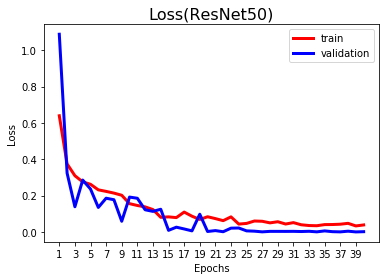

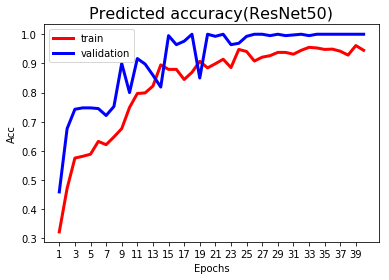

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(ResNet50)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(ResNet50)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:     75    81    77    79
Predicted:     75    81    77    79


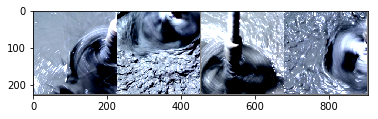

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [9]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  105	0	0	0	

Actual 77  0	105	0	0	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

